In [1]:
from pyspark.sql import SparkSession

    # .master("local[4]") \
spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "1024") \
    .config("spark.sql.orc.columnarReaderBatchSize", "1024") \
    .config("spark.sql.shuffle.partitions", "128") \
    .config("spark.default.parallelism", "128") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark

25/05/13 14:41:41 WARN Utils: Your hostname, Daniels-MacBook-Pro-1035.local resolves to a loopback address: 127.0.0.1; using 172.26.0.224 instead (on interface en0)
25/05/13 14:41:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/13 14:41:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark.sql("""
SELECT
  id,
  title,
  description,
  physicalDescription,
  lettering,
  referenceNumber,
  edition,

  -- Contributors information
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        contributors,
        c -> CONCAT(c.agent.label, ' (', COALESCE(c.roles[0].label, 'contributor'), ')')
      ),
      '; '
    ),
    ''
  ) AS contributor_names,

  -- Alternative titles
  COALESCE(ARRAY_JOIN(alternativeTitles, '; '), '') AS alternative_titles,

  -- Subjects
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        subjects,
        s -> s.label
      ),
      '; '
    ),
    ''
  ) AS subject_labels,

  -- Genres
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        genres,
        g -> g.label
      ),
      '; '
    ),
    ''
  ) AS genre_labels,

  -- Languages
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        languages,
        l -> l.label
      ),
      '; '
    ),
    ''
  ) AS language_labels,

  -- Production information
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        production,
        p -> p.label
      ),
      '; '
    ),
    ''
  ) AS production_info,

  -- Notes
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        notes,
        n -> ARRAY_JOIN(n.contents, ' ')
      ),
      '; '
    ),
    ''
  ) AS note_contents,

  -- Work type
  COALESCE(workType.label, '') AS work_type,

  -- Availability
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        availabilities,
        a -> a.label
      ),
      '; '
    ),
    ''
  ) AS availability_labels

FROM works
""").write.saveAsTable("works_text_flattened", mode="overwrite")

spark.table("works_text_flattened").show(truncate=False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------

# Text Analysis of Works Collection

In this section, we'll analyze the text fields in the `works_text_flattened` table to gain insights into the collection. We'll perform:

1. Basic text statistics (length, word count, etc.)
2. Visualize distribution of text length with histograms and boxplots
3. Apply text analysis techniques like term frequency, n-grams, and sentiment analysis
4. Explore relationships between different text fields
5. Apply novel text characterization methods

In [2]:
# Import necessary libraries for text analysis and visualization
import pyspark.sql.functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

# Configure matplotlib for better display
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

In [3]:
# Load the works_text_flattened table
df = spark.table("works_text_flattened")

# Cache the table for faster processing
df.cache()

# Print schema to verify structure
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- physicalDescription: string (nullable = true)
 |-- lettering: string (nullable = true)
 |-- referenceNumber: string (nullable = true)
 |-- edition: string (nullable = true)
 |-- contributor_names: string (nullable = true)
 |-- alternative_titles: string (nullable = true)
 |-- subject_labels: string (nullable = true)
 |-- genre_labels: string (nullable = true)
 |-- language_labels: string (nullable = true)
 |-- production_info: string (nullable = true)
 |-- note_contents: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- availability_labels: string (nullable = true)



In [25]:
# Create a DataFrame with text statistics for each field
text_stats = df.select(
    "id",
    # Calculate various metrics for title
    F.length("title").alias("title_length"),
    F.size(F.split("title", "\\s+")).alias("title_word_count"),
    
    # Calculate metrics for description
    F.length("description").alias("description_length"),
    F.size(F.split("description", "\\s+")).alias("description_word_count"),
    
    # Calculate metrics for physicalDescription
    F.length("physicalDescription").alias("physical_desc_length"),
    F.size(F.split("physicalDescription", "\\s+")).alias("physical_desc_word_count"),
    
    # Calculate metrics for notes
    F.length("note_contents").alias("notes_length"),
    F.size(F.split("note_contents", "\\s+")).alias("notes_word_count"),
    
    # Calculate metrics for subjects
    F.length("subject_labels").alias("subjects_length"),
    F.size(F.split("subject_labels", ";")).alias("subject_count"),
    
    # Calculate metrics for genres
    F.length("genre_labels").alias("genres_length"),
    F.size(F.split("genre_labels", ";")).alias("genre_count"),
    
    # Calculate metrics for contributors
    F.length("contributor_names").alias("contributors_length"),
    F.size(F.split("contributor_names", ";")).alias("contributor_count"),
)

# Calculate summary statistics
summary_stats = text_stats.summary()
summary_stats.show()

+-------+--------+------------------+------------------+------------------+----------------------+--------------------+------------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+------------------+
|summary|      id|      title_length|  title_word_count|description_length|description_word_count|physical_desc_length|physical_desc_word_count|      notes_length| notes_word_count|  subjects_length|     subject_count|     genres_length|       genre_count|contributors_length| contributor_count|
+-------+--------+------------------+------------------+------------------+----------------------+--------------------+------------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+------------------+
|  count| 1167387|           1167387|           1167387|            237038|               1167387|              

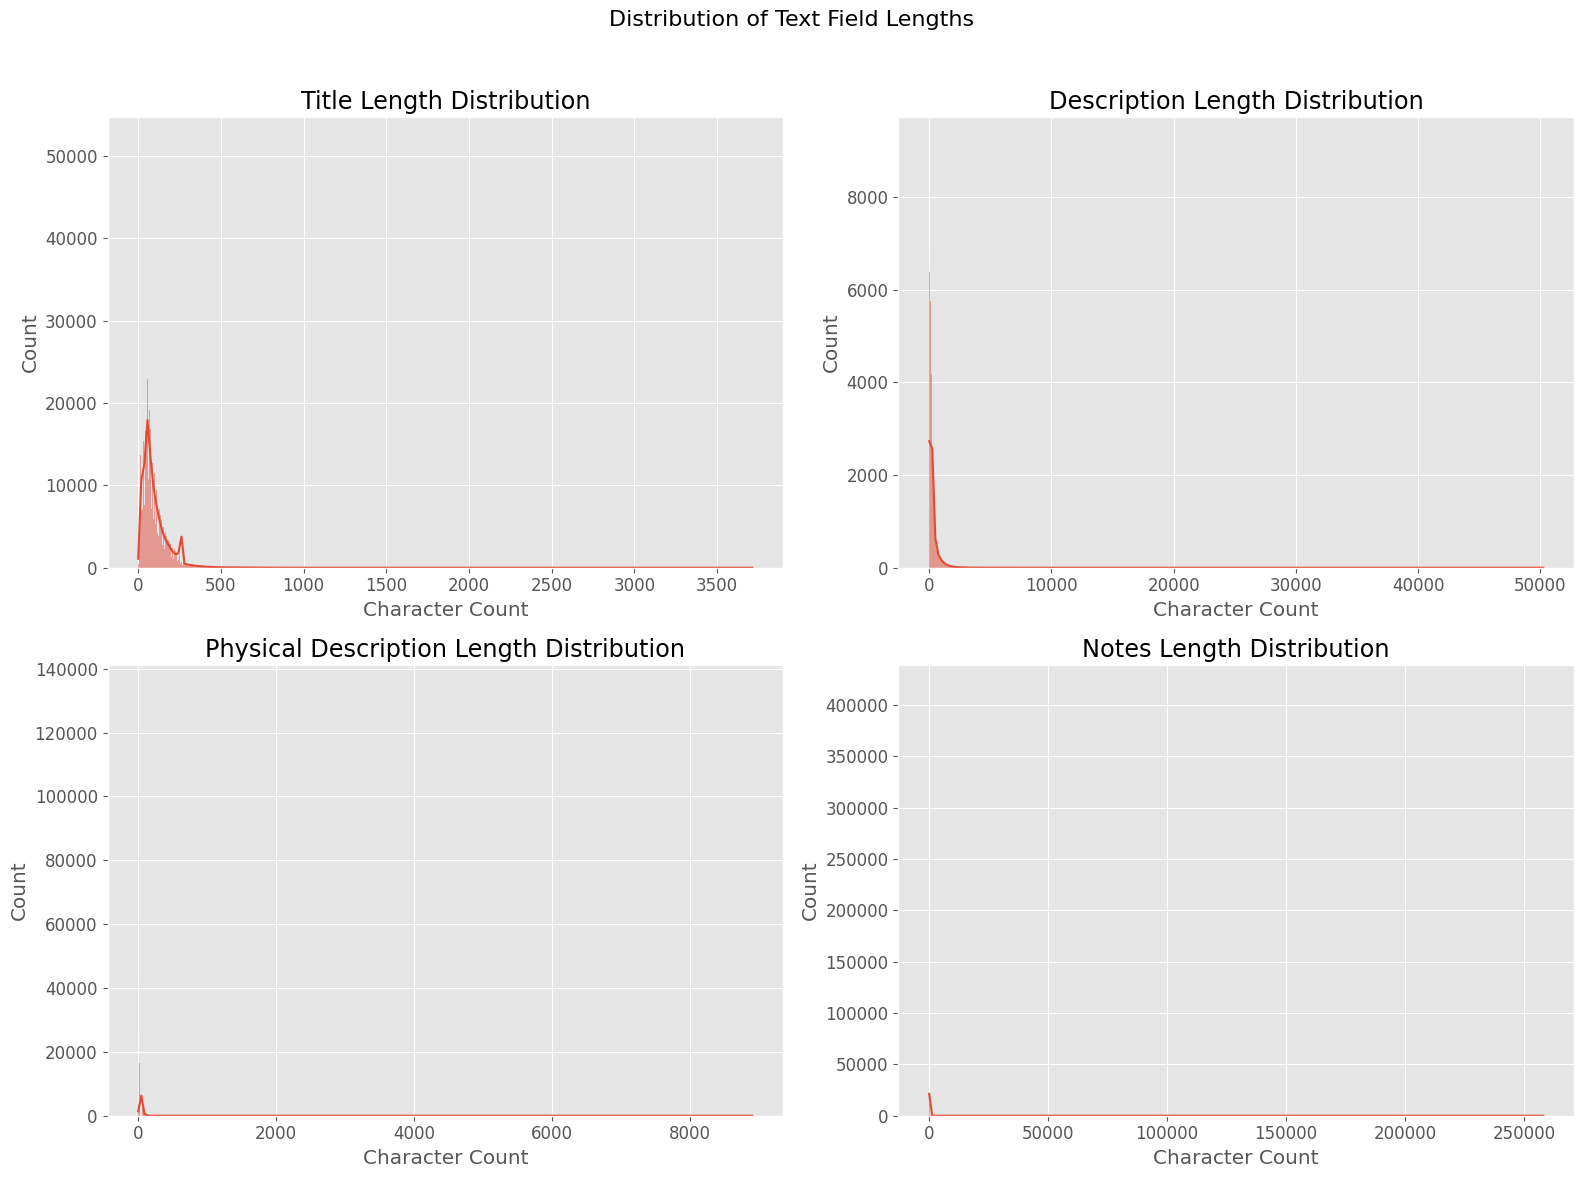

In [26]:
# Convert text statistics to pandas for visualization
text_stats_pd = text_stats.toPandas()

# Create a figure with multiple subplots for histograms of text lengths
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Text Field Lengths', fontsize=16)

# Plot histograms with KDE for different text fields
sns.histplot(text_stats_pd['title_length'].dropna(), kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Title Length Distribution')
axes[0, 0].set_xlabel('Character Count')

sns.histplot(text_stats_pd['description_length'].dropna(), kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Description Length Distribution')
axes[0, 1].set_xlabel('Character Count')

sns.histplot(text_stats_pd['physical_desc_length'].dropna(), kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Physical Description Length Distribution')
axes[1, 0].set_xlabel('Character Count')

sns.histplot(text_stats_pd['notes_length'].dropna(), kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Notes Length Distribution')
axes[1, 1].set_xlabel('Character Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

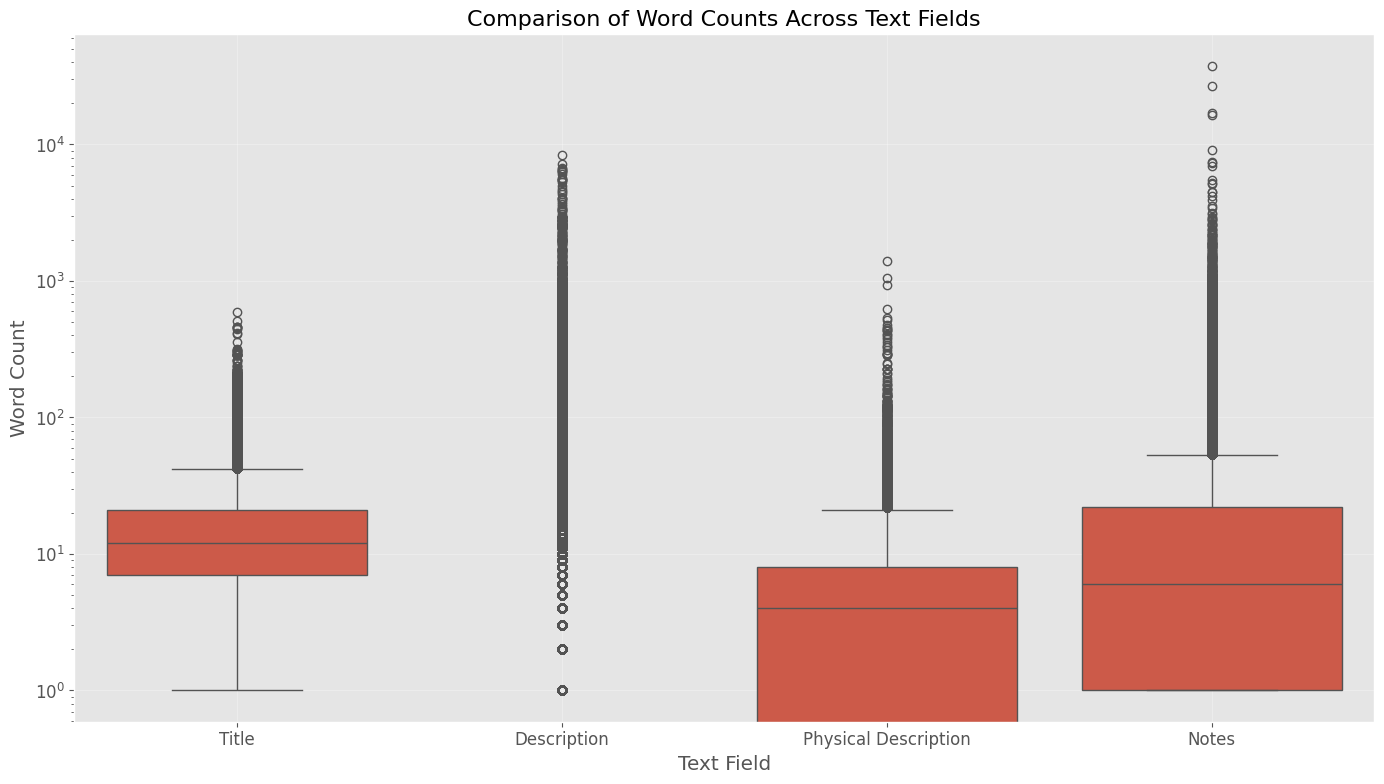

In [ ]:
# Create boxplots to compare word counts across different text fields
# Prepare data for boxplot
box_data = pd.DataFrame({
    'Title': text_stats_pd['title_word_count'],
    'Description': text_stats_pd['description_word_count'],
    'Physical Description': text_stats_pd['physical_desc_word_count'],
    'Notes': text_stats_pd['notes_word_count']
})

melted_data = pd.melt(box_data, var_name='Text Field', value_name='Word Count')

plt.figure(figsize=(14, 8))
sns.boxplot(x='Text Field', y='Word Count', data=melted_data)
plt.title('Comparison of Word Counts Across Text Fields', fontsize=16)
plt.yscale('log')  # Use log scale for better visualization if there are outliers
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Text Complexity Analysis

Let's analyze the complexity and readability of the text fields using metrics such as:
- Average word length
- Lexical diversity (ratio of unique words to total words)
- Presence of specialized vocabulary
- Sentiment patterns

In [20]:
# Calculate text complexity metrics
complexity_df = df.select(
    "id",
    "title",
    "description",
    "physicalDescription",
    "note_contents"
)

# Define UDF for calculating average word length
@F.udf(returnType=FloatType())
def avg_word_length(text):
    if not text or len(text.strip()) == 0:
        return None
    words = [w for w in text.split() if len(w.strip()) > 0]
    if not words:
        return 0.0
    return sum(len(word) for word in words) / len(words)

# Define UDF for calculating lexical diversity (unique words / total words)
@F.udf(returnType=FloatType())
def lexical_diversity(text):
    if not text or len(text.strip()) == 0:
        return None
    words = [w.lower() for w in text.split() if len(w.strip()) > 0]
    if not words:
        return 0.0
    return len(set(words)) / len(words)

# Apply the UDFs to calculate complexity metrics
complexity_analysis = complexity_df.select(
    "id",
    avg_word_length("title").alias("title_avg_word_length"),
    lexical_diversity("title").alias("title_lexical_diversity"),
    
    avg_word_length("description").alias("description_avg_word_length"),
    lexical_diversity("description").alias("description_lexical_diversity"),
    
    avg_word_length("physicalDescription").alias("physical_desc_avg_word_length"),
    lexical_diversity("physicalDescription").alias("physical_desc_lexical_diversity"),
    
    avg_word_length("note_contents").alias("notes_avg_word_length"),
    lexical_diversity("note_contents").alias("notes_lexical_diversity")
)

# Show summary of complexity metrics
complexity_analysis.summary().show()

+-------+--------+---------------------+-----------------------+---------------------------+-----------------------------+-----------------------------+-------------------------------+---------------------+-----------------------+
|summary|      id|title_avg_word_length|title_lexical_diversity|description_avg_word_length|description_lexical_diversity|physical_desc_avg_word_length|physical_desc_lexical_diversity|notes_avg_word_length|notes_lexical_diversity|
+-------+--------+---------------------+-----------------------+---------------------------+-----------------------------+-----------------------------+-------------------------------+---------------------+-----------------------+
|  count| 1167387|              1167144|                1167144|                     237027|                       237027|                       863135|                         863135|               749716|                 749716|
|   mean|    NULL|    5.759688457011237|     0.9424069243108484|         6.0

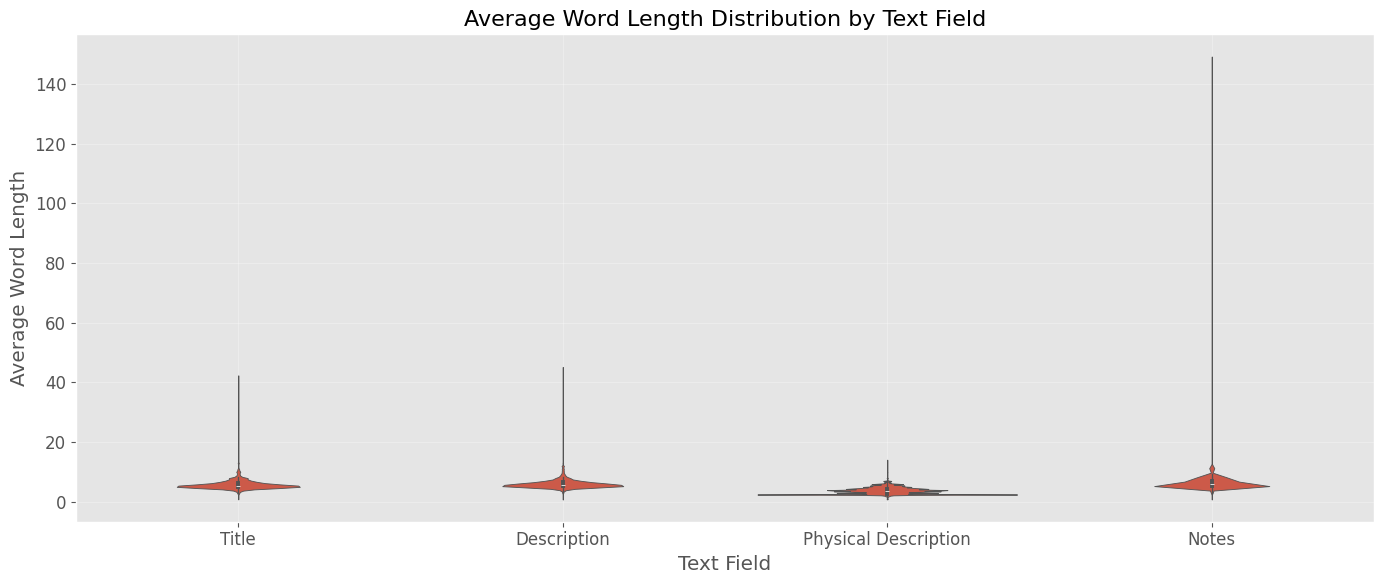

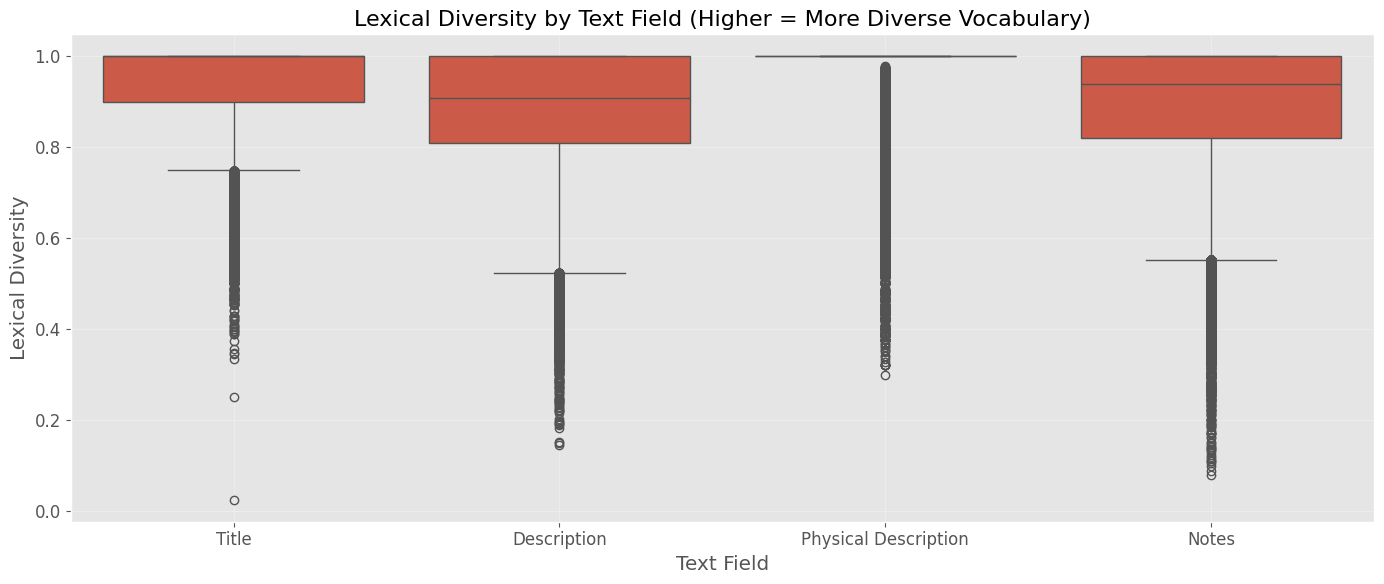

In [21]:
# Visualization of text complexity metrics
complexity_pd = complexity_analysis.toPandas()

# Plot average word length comparison across text fields
plt.figure(figsize=(14, 6))
avg_word_data = pd.DataFrame({
    'Title': complexity_pd['title_avg_word_length'],
    'Description': complexity_pd['description_avg_word_length'],
    'Physical Description': complexity_pd['physical_desc_avg_word_length'],
    'Notes': complexity_pd['notes_avg_word_length']
})
avg_word_melted = pd.melt(avg_word_data, var_name='Text Field', value_name='Average Word Length')

sns.violinplot(x='Text Field', y='Average Word Length', data=avg_word_melted)
plt.title('Average Word Length Distribution by Text Field', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot lexical diversity comparison across text fields
plt.figure(figsize=(14, 6))
lex_div_data = pd.DataFrame({
    'Title': complexity_pd['title_lexical_diversity'],
    'Description': complexity_pd['description_lexical_diversity'],
    'Physical Description': complexity_pd['physical_desc_lexical_diversity'],
    'Notes': complexity_pd['notes_lexical_diversity']
})
lex_div_melted = pd.melt(lex_div_data, var_name='Text Field', value_name='Lexical Diversity')

sns.boxplot(x='Text Field', y='Lexical Diversity', data=lex_div_melted)
plt.title('Lexical Diversity by Text Field (Higher = More Diverse Vocabulary)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Term Frequency Analysis

Let's explore the most common words and phrases in different text fields to understand the content better.

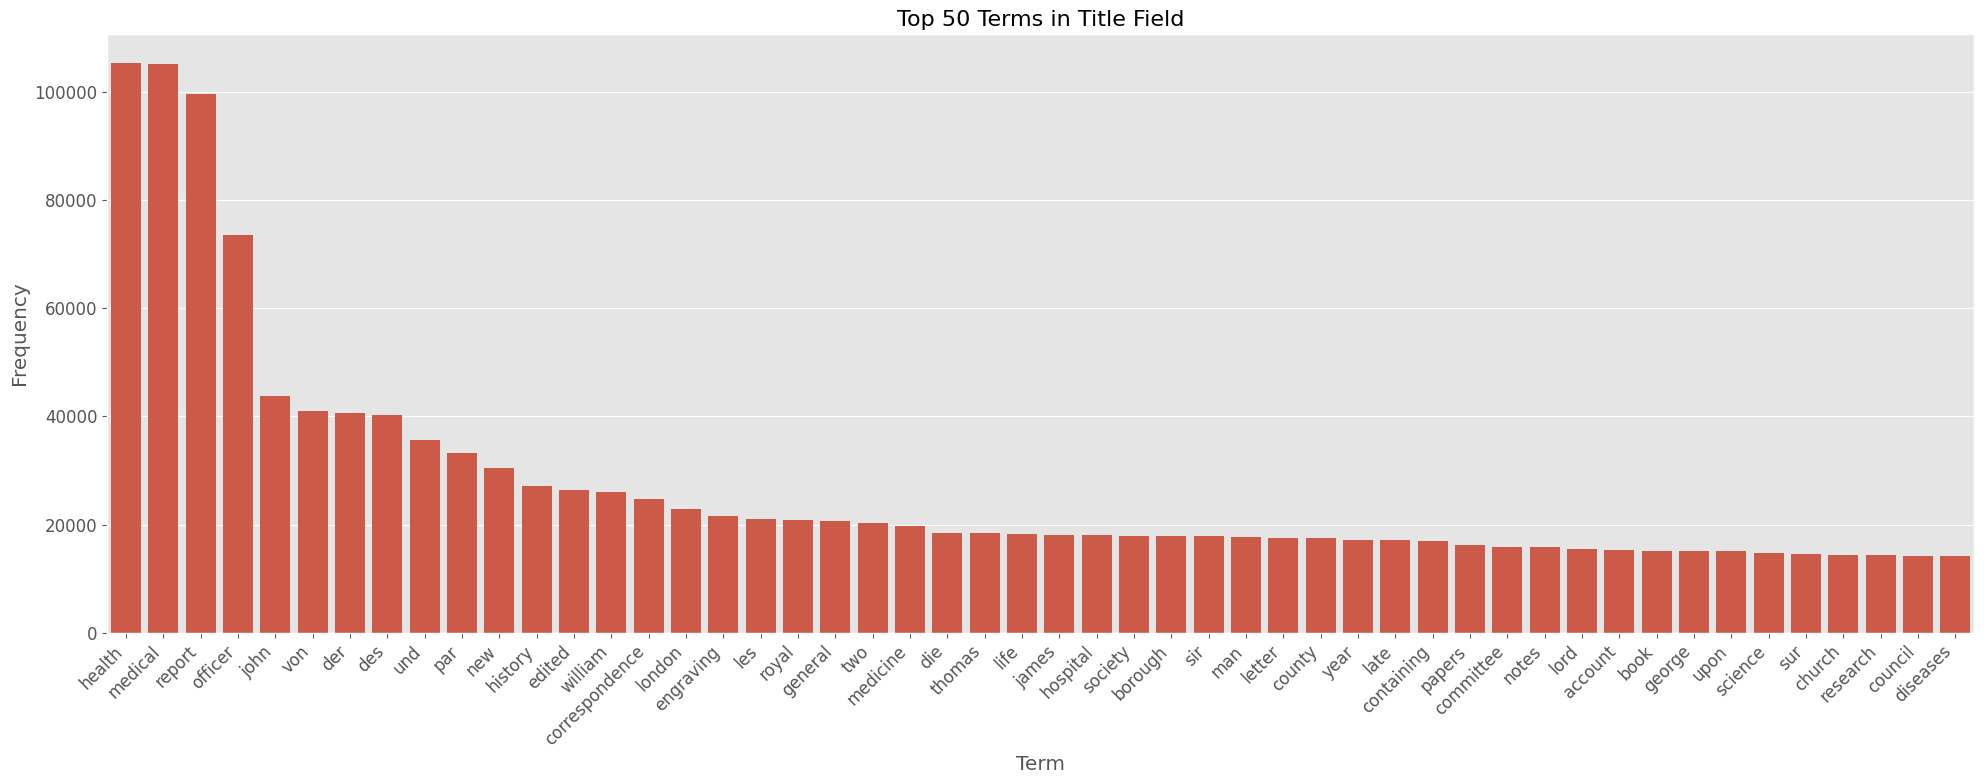

In [29]:
# Term frequency analysis for the description field
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, StopWordsRemover
from pyspark.sql.functions import explode, col

# Select non-empty descriptions
titles_df = df.filter(F.length("title") > 0).select("id", "title")

# 1) Split on non-word chars (keeps only letters & numbers)
regex_tokenizer = RegexTokenizer(
    inputCol="title",
    outputCol="words",
    pattern="\\W+",        # splits on anything other than [A-Za-z0-9_]
    minTokenLength=2       # drop 1-letter “words” if you like
    )

titles_words_df = regex_tokenizer.transform(titles_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
titles_filtered_df = remover.transform(titles_words_df)

# Create a custom UDF to filter out numbers and short tokens
@F.udf(returnType=ArrayType(StringType()))
def clean_tokens(tokens):
    if not tokens:
        return []
    return [token.lower() for token in tokens if len(token) > 2 and not token.isdigit()]


titles_cleaned_df = titles_filtered_df.withColumn(
    "clean_words", clean_tokens(
        col("filtered_words")))

# Calculate term frequencies
cv = CountVectorizer(inputCol="clean_words", outputCol="term_freq", minDF=5, vocabSize=10000)
titles_cv_model = cv.fit(titles_cleaned_df)
titles_term_freq_df = titles_cv_model.transform(titles_cleaned_df)

# Extract vocabulary from the CountVectorizerModel
titles_vocab = titles_cv_model.vocabulary

def extract_term_counts_fn(vocab_list):
    @F.udf(returnType=ArrayType(StructType([
        StructField("term", StringType()),
        StructField("count", IntegerType())
    ])))
    def extract(vector):
        indices = vector.indices.tolist()
        values = vector.values.tolist()
        return [(vocab_list[idx], int(val))
                for idx, val in zip(indices, values)]
    return extract


# Apply it using closure:
titles_term_counts_df = titles_term_freq_df.withColumn(
    "term_counts",
    extract_term_counts_fn(titles_vocab)(col("term_freq"))
)

# Explode the array to get individual term-count pairs
titles_exploded_df = titles_term_counts_df.select(
    "id",
    explode("term_counts").alias("term_count")
)

# Extract term and count from the struct
titles_term_count_df = titles_exploded_df.select(
    "id", 
    col("term_count.term").alias("term"),
    col("term_count.count").alias("count")
)

# Group by term and sum counts
titles_term_totals = titles_term_count_df.groupBy(
    "term").agg(F.sum("count").alias("total_count"))

titles_top_terms = titles_term_totals.orderBy(col("total_count").desc()).limit(50)
titles_top_terms_pd = titles_top_terms.toPandas()

# Plot top terms
plt.figure(figsize=(20, 8))
sns.barplot(x="term", y="total_count", data=titles_top_terms_pd)
plt.title('Top 50 Terms in Title Field', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Term')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

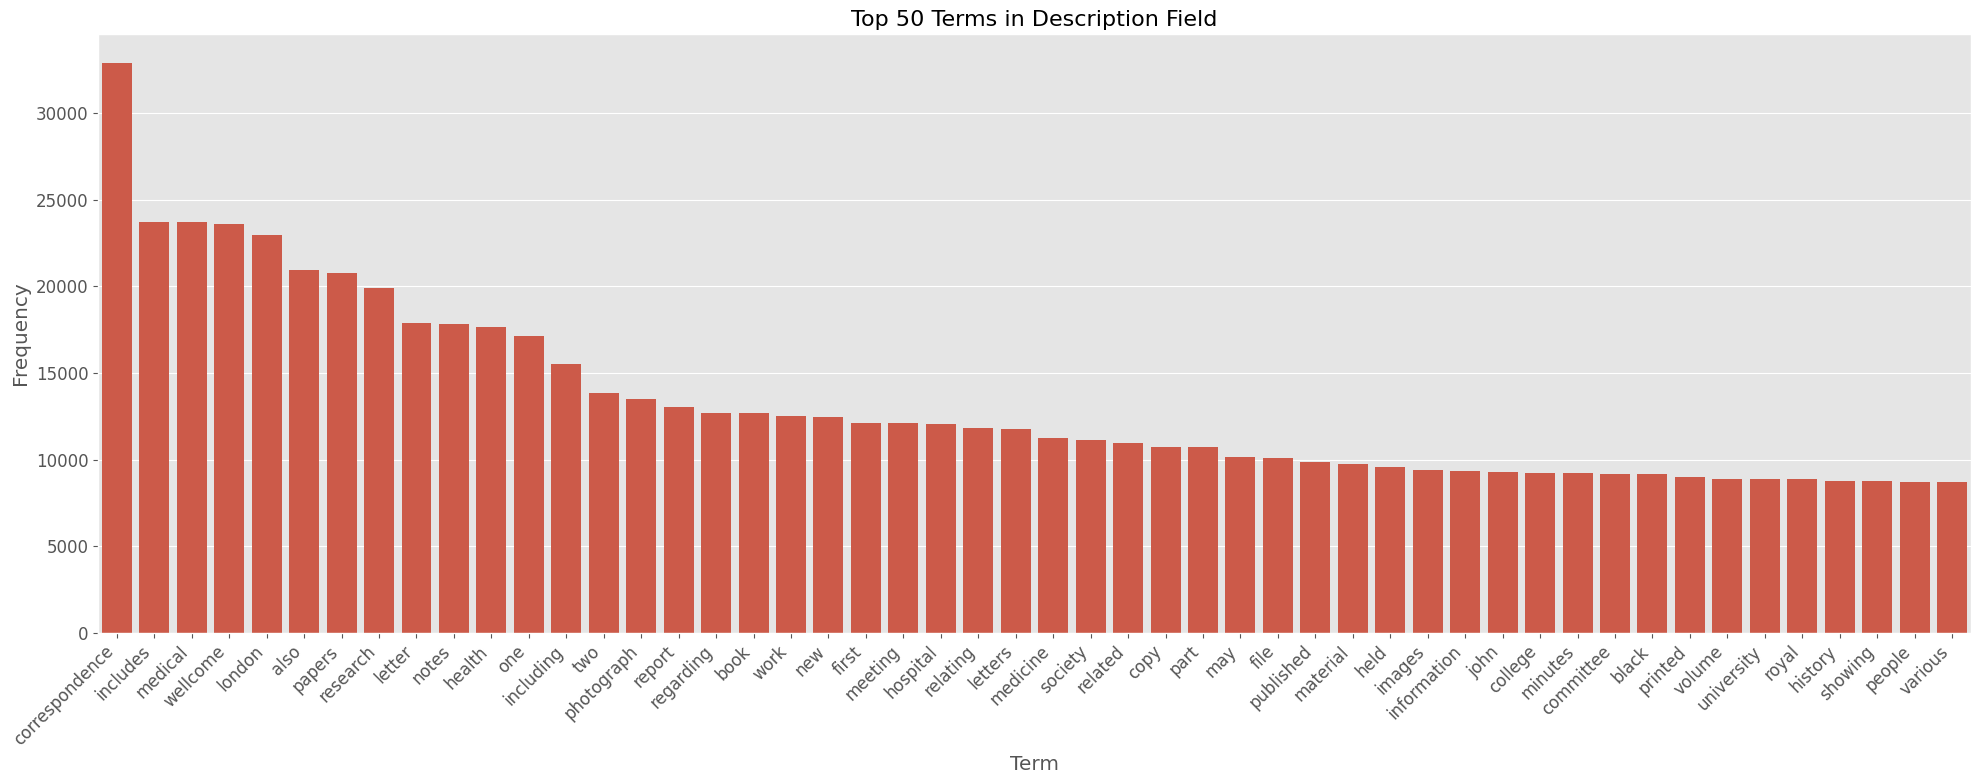

In [27]:
# Term frequency analysis for the description field
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, StopWordsRemover
from pyspark.sql.functions import explode, col

# Select non-empty descriptions
descriptions_df = df.filter(F.length("description") > 0).select("id", "description")

# 1) Split on non-word chars (keeps only letters & numbers)
regex_tokenizer = RegexTokenizer(
    inputCol="description",
    outputCol="words",
    pattern="\\W+",        # splits on anything other than [A-Za-z0-9_]
    minTokenLength=2       # drop 1-letter “words” if you like
)
descriptions_words_df = regex_tokenizer.transform(descriptions_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
descriptions_filtered_df = remover.transform(descriptions_words_df)

# Create a custom UDF to filter out numbers and short tokens
@F.udf(returnType=ArrayType(StringType()))
def clean_tokens(tokens):
    if not tokens:
        return []
    return [token.lower() for token in tokens if len(token) > 2 and not token.isdigit()]


descriptions_cleaned_df = descriptions_filtered_df.withColumn(
    "clean_words", clean_tokens(col("filtered_words")))

# Calculate term frequencies
cv = CountVectorizer(inputCol="clean_words", outputCol="term_freq", minDF=5, vocabSize=10000)
descriptions_cv_model = cv.fit(descriptions_cleaned_df)
descriptions_term_freq_df = descriptions_cv_model.transform(
    descriptions_cleaned_df)

# Extract vocabulary from the CountVectorizerModel
descriptions_vocab = descriptions_cv_model.vocabulary

def extract_term_counts_fn(vocab_list):
    @F.udf(returnType=ArrayType(StructType([
        StructField("term", StringType()),
        StructField("count", IntegerType())
    ])))
    def extract(vector):
        indices = vector.indices.tolist()
        values = vector.values.tolist()
        return [(vocab_list[idx], int(val))
                for idx, val in zip(indices, values)]
    return extract


# Apply it using closure:
descriptions_term_counts_df = descriptions_term_freq_df.withColumn(
    "term_counts",
    extract_term_counts_fn(descriptions_vocab)(col("term_freq"))
)

# Explode the array to get individual term-count pairs
descriptions_exploded_df = descriptions_term_counts_df.select(
    "id",
    explode("term_counts").alias("term_count")
)

# Extract term and count from the struct
descriptions_term_count_df = descriptions_exploded_df.select(
    "id", 
    col("term_count.term").alias("term"),
    col("term_count.count").alias("count")
)

# Group by term and sum counts
descriptions_term_totals = descriptions_term_count_df.groupBy(
    "term").agg(F.sum("count").alias("total_count"))

top_terms = descriptions_term_totals.orderBy(
    col("total_count").desc()).limit(50)
descriptions_top_terms_pd = top_terms.toPandas()

# Plot top terms
plt.figure(figsize=(20, 8))
sns.barplot(x="term", y="total_count", data=descriptions_top_terms_pd)
plt.title('Top 50 Terms in Description Field', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Term')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

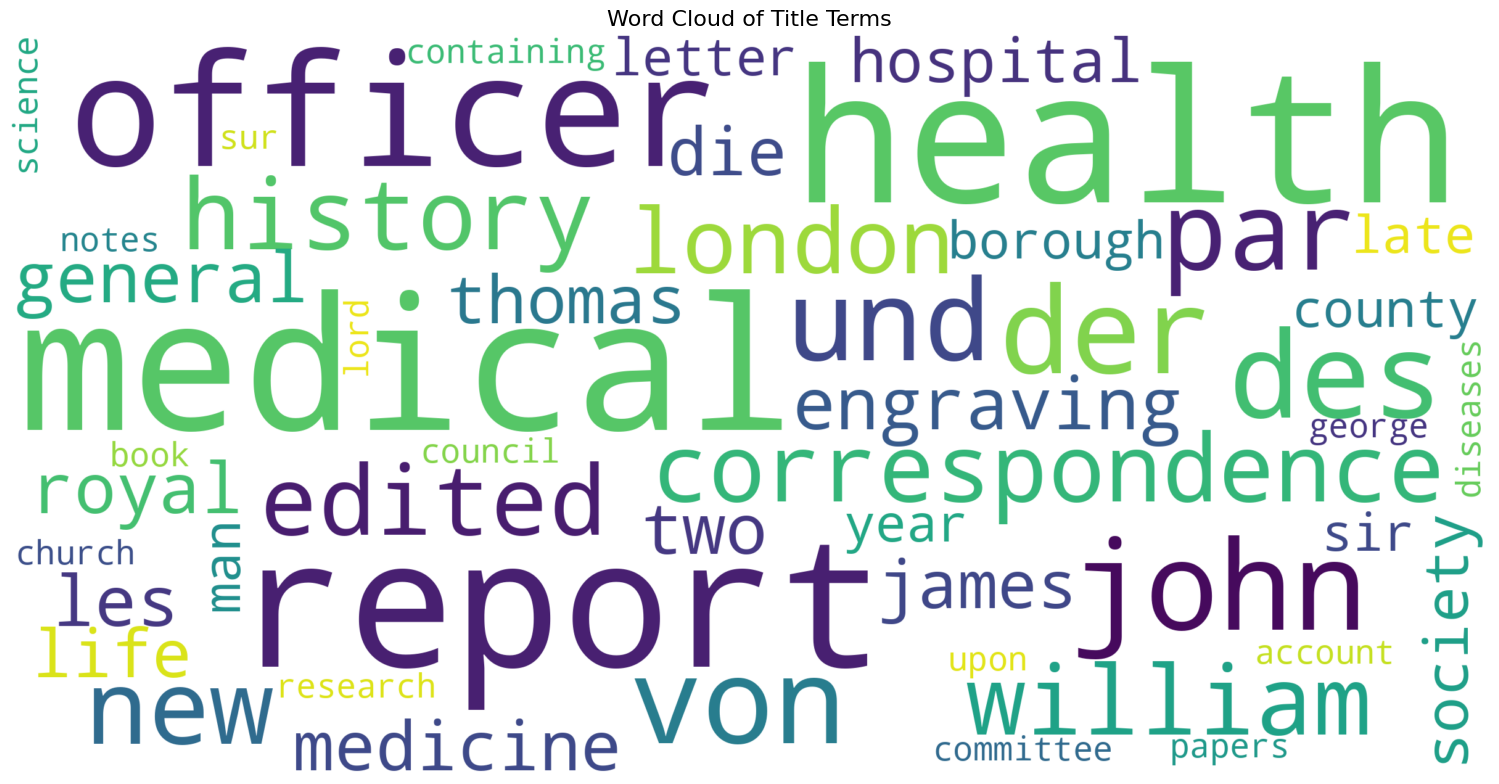

In [30]:
# Generate a word cloud visualization
try:
    from wordcloud import WordCloud
    
    # Create a dictionary from the top terms dataframe
    titles_word_freq = dict(zip(titles_top_terms_pd['term'], titles_top_terms_pd['total_count']))
    
    # Generate word cloud
    titles_wordcloud = WordCloud(
        width=800, height=400, background_color='white', max_words=100,
        max_font_size=100, scale=3, random_state=42).generate_from_frequencies(
        titles_word_freq)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(titles_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Title Terms', fontsize=16)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("WordCloud package not available. Install using: pip install wordcloud")

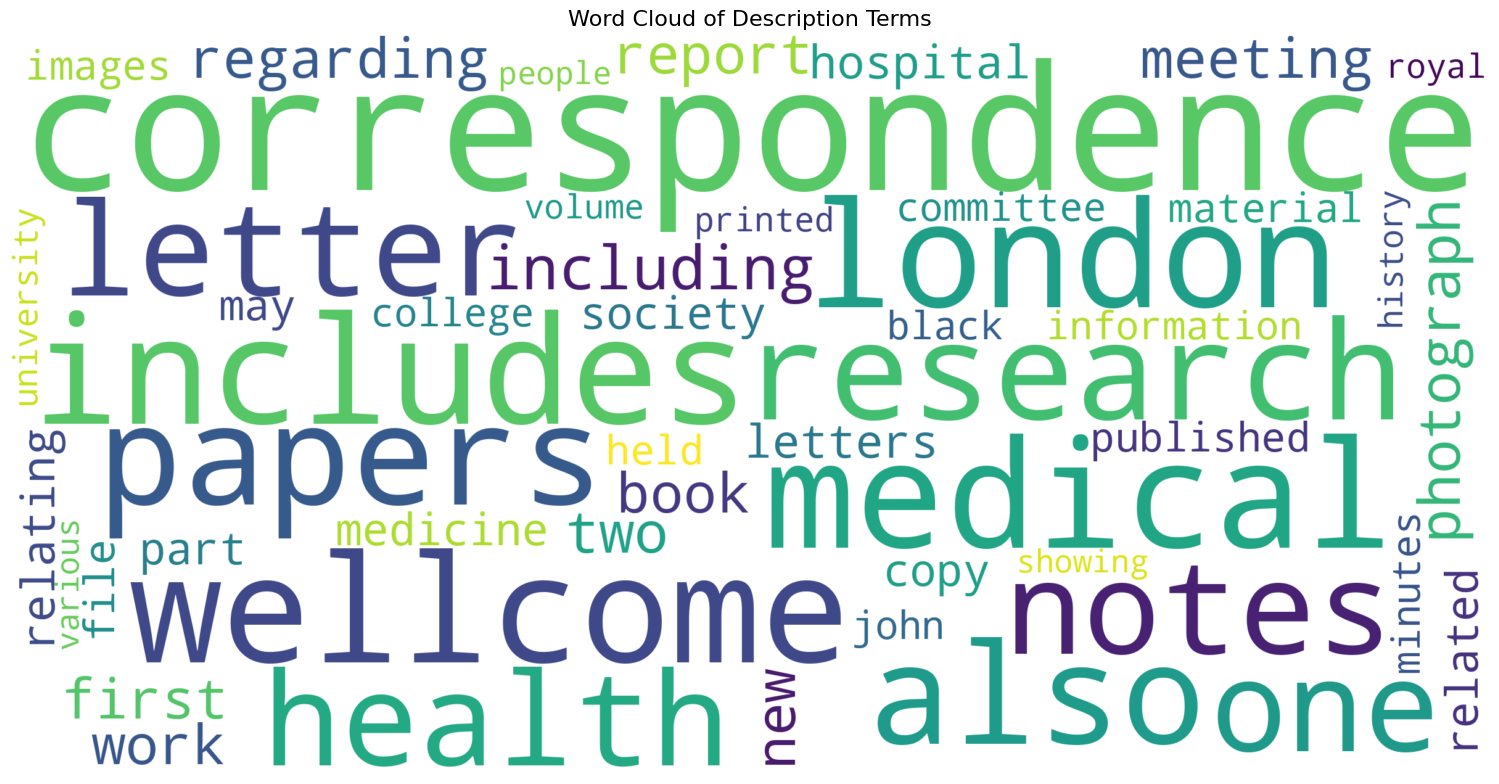

In [31]:
# Generate a word cloud visualization
try:
    from wordcloud import WordCloud
    
    # Create a dictionary from the top terms dataframe
    descriptions_word_freq = dict(zip(descriptions_top_terms_pd['term'], descriptions_top_terms_pd['total_count']))
    
    # Generate word cloud
    descriptions_wordcloud = WordCloud(
        width=800, height=400, background_color='white', max_words=100,
        max_font_size=100, scale=3, random_state=42).generate_from_frequencies(
        descriptions_word_freq)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(descriptions_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Description Terms', fontsize=16)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("WordCloud package not available. Install using: pip install wordcloud")

## N-gram Analysis

Let's analyze common phrases (bigrams and trigrams) to identify multi-word expressions and common patterns in the text.

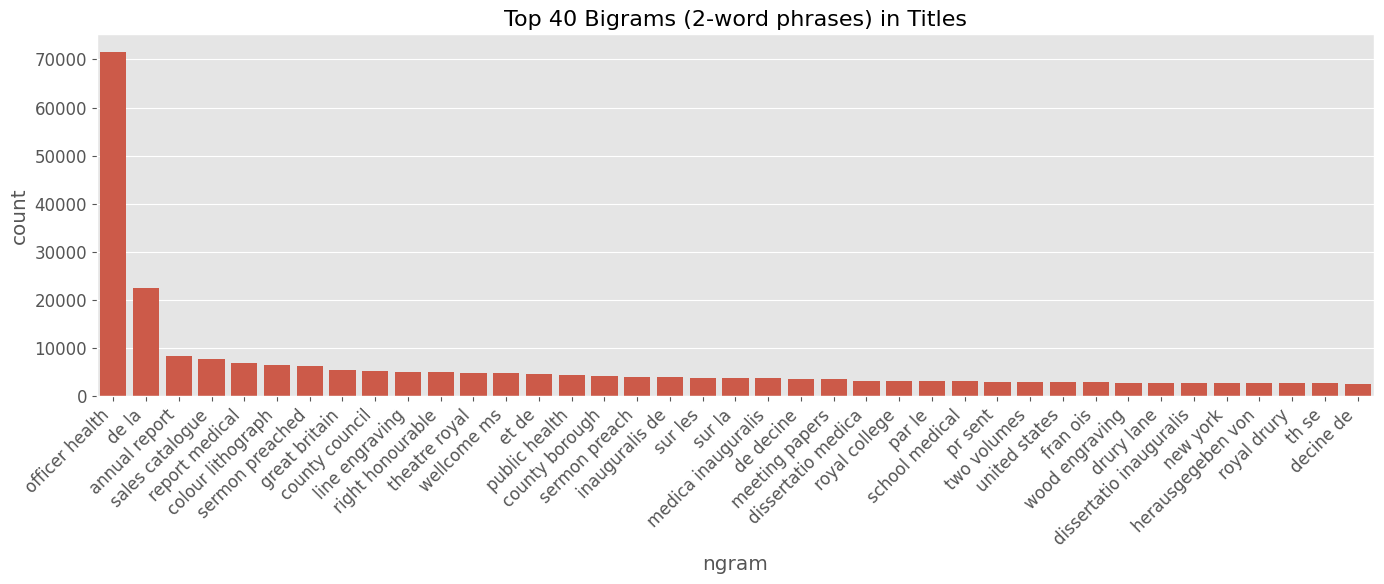

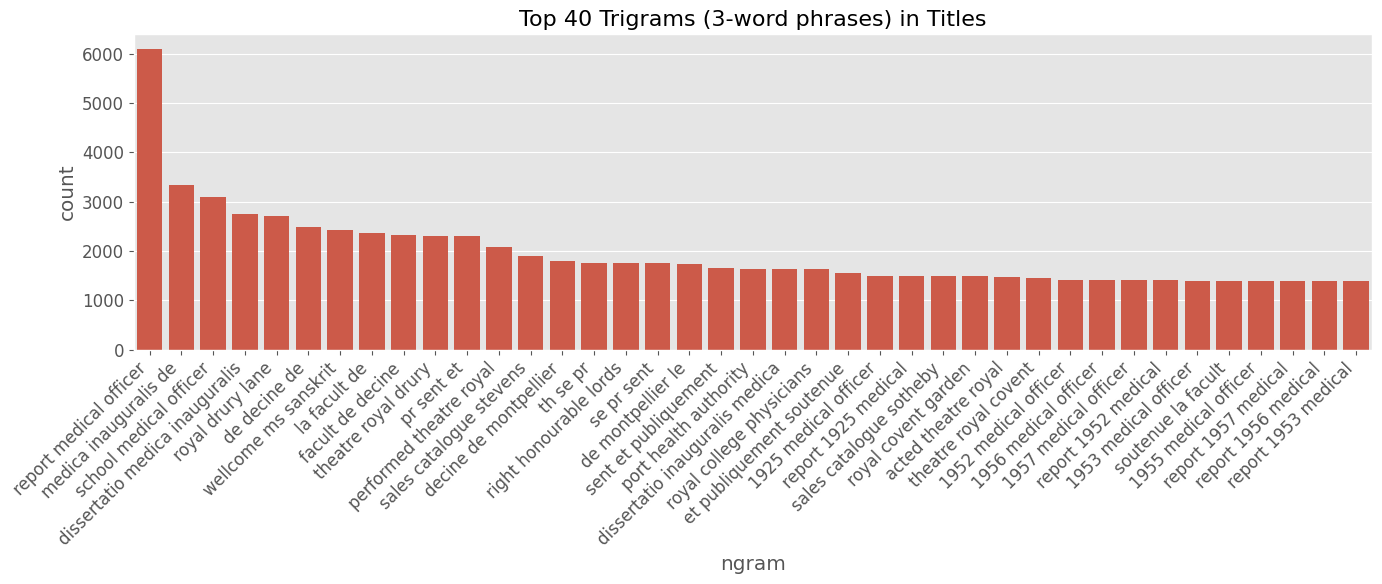

In [32]:
# N-gram analysis to identify common phrases in descriptions
from pyspark.ml.feature import NGram

# Add bigrams (2-word phrases)
bigram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")
titles_bigram_df = bigram.transform(titles_filtered_df)

# Add trigrams (3-word phrases)
trigram = NGram(n=3, inputCol="filtered_words", outputCol="trigrams")
titles_ngram_df = trigram.transform(titles_bigram_df)

# Function to get top n-grams
def get_top_ngrams(df, ngram_col, n=40):
    # Explode the n-grams to get individual entries
    exploded_df = df.select(explode(col(ngram_col)).alias("ngram"))
    
    # Count the occurrences of each n-gram
    ngram_counts = exploded_df.groupBy("ngram").count().orderBy(col("count").desc())
    
    # Get top n n-grams
    return ngram_counts.limit(n).toPandas()


# Get top bigrams
titles_top_bigrams = get_top_ngrams(titles_ngram_df, "bigrams")

# Get top trigrams
titles_top_trigrams = get_top_ngrams(titles_ngram_df, "trigrams")

# Plot top bigrams
plt.figure(figsize=(14, 6))
sns.barplot(x="ngram", y="count", data=titles_top_bigrams[1:])
plt.title('Top 40 Bigrams (2-word phrases) in Titles', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot top trigrams
plt.figure(figsize=(14, 6))
sns.barplot(x="ngram", y="count", data=titles_top_trigrams[1:])
plt.title('Top 40 Trigrams (3-word phrases) in Titles', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

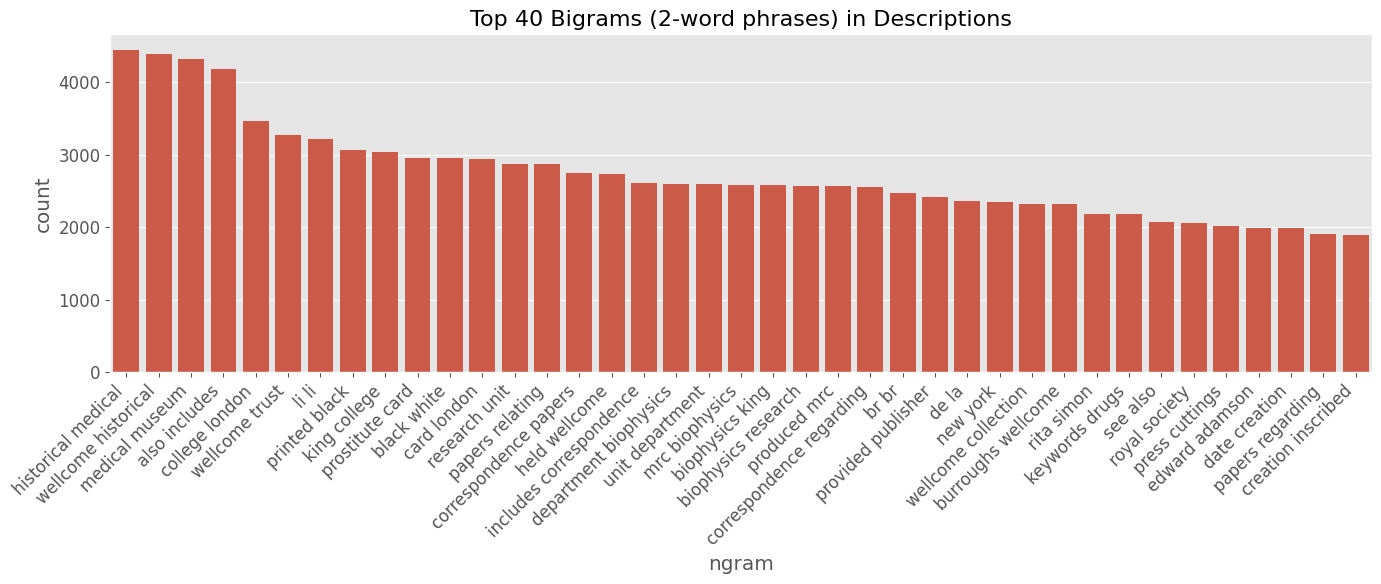

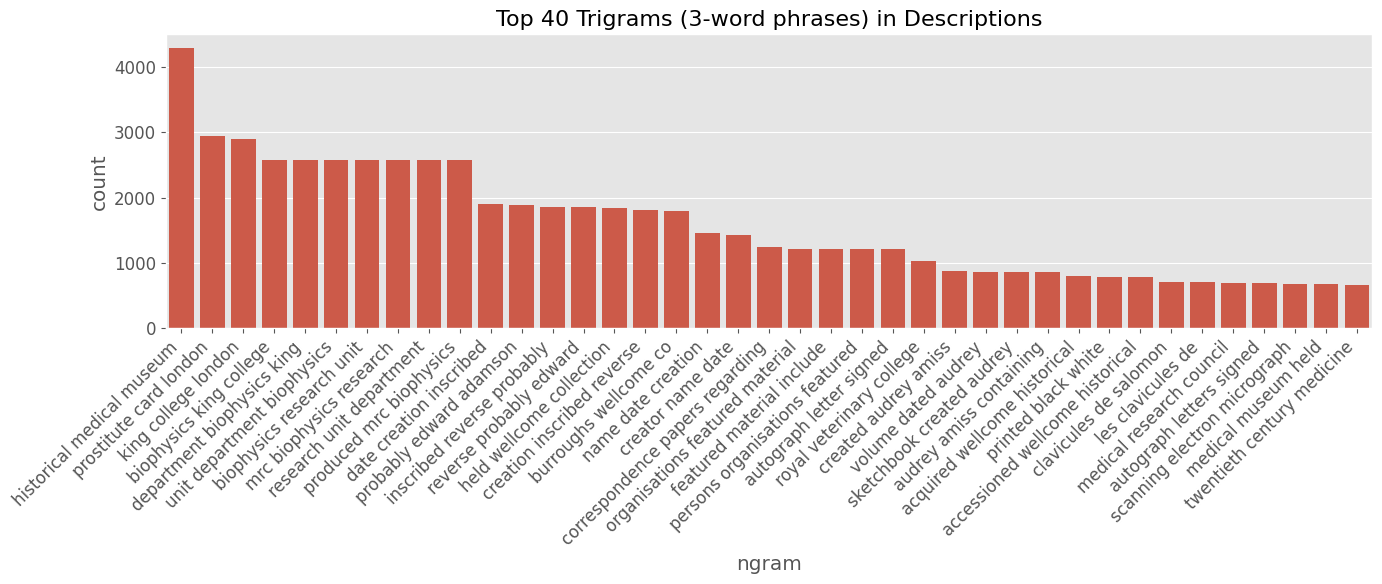

In [33]:
# N-gram analysis to identify common phrases in descriptions
from pyspark.ml.feature import NGram

# Add bigrams (2-word phrases)
bigram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")
descriptions_bigram_df = bigram.transform(descriptions_filtered_df)

# Add trigrams (3-word phrases)
trigram = NGram(n=3, inputCol="filtered_words", outputCol="trigrams")
descriptions_ngram_df = trigram.transform(descriptions_bigram_df)

# Function to get top n-grams
def get_top_ngrams(df, ngram_col, n=40):
    # Explode the n-grams to get individual entries
    exploded_df = df.select(explode(col(ngram_col)).alias("ngram"))
    
    # Count the occurrences of each n-gram
    ngram_counts = exploded_df.groupBy("ngram").count().orderBy(col("count").desc())
    
    # Get top n n-grams
    return ngram_counts.limit(n).toPandas()


# Get top bigrams
descriptions_top_bigrams = get_top_ngrams(descriptions_ngram_df, "bigrams")

# Get top trigrams
descriptions_top_trigrams = get_top_ngrams(descriptions_ngram_df, "trigrams")

# Plot top bigrams
plt.figure(figsize=(14, 6))
sns.barplot(x="ngram", y="count", data=descriptions_top_bigrams[1:])
plt.title('Top 40 Bigrams (2-word phrases) in Descriptions', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot top trigrams
plt.figure(figsize=(14, 6))
sns.barplot(x="ngram", y="count", data=descriptions_top_trigrams[1:])
plt.title('Top 40 Trigrams (3-word phrases) in Descriptions', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Topic Modeling

Let's use Latent Dirichlet Allocation (LDA) to discover abstract topics in the collection.

### 1. Generative Process

LDA assumes the following process for generating each document in the corpus:

1. **Choose document-level topic proportions**  
   For each document *d*, draw a vector of topic proportions  
   $$
     \boldsymbol\theta_d \sim \mathrm{Dirichlet}(\boldsymbol\alpha)
   $$  
   where $\boldsymbol\alpha$ is a $K$-dimensional hyperparameter ( $K = $ number of topics).

2. **Choose topic-level word distributions**  
   For each topic *k*, draw a word distribution  
   $$
     \boldsymbol\phi_k \sim \mathrm{Dirichlet}(\boldsymbol\beta)
   $$  
   where $\boldsymbol\beta$ is a $V$-dimensional hyperparameter ( $V = $ vocabulary size).

3. **Generate words**  
   For each word position *n* in document *d*:  
   - Draw a topic assignment  
     $$
       z_{d,n} \sim \mathrm{Categorical}(\boldsymbol\theta_d)
     $$  
   - Draw the observed word  
     $$
       w_{d,n} \sim \mathrm{Categorical}(\boldsymbol\phi_{z_{d,n}})
     $$

---

### 2. Dirichlet Priors and Their Role

- **Dirichlet over topics ($\alpha$)**  
  Controls how “mixed” each document’s topic distribution is:  
  - Small $\alpha$ ⇒ documents concentrate on few topics  
  - Large $\alpha$ ⇒ documents spread evenly over many topics  

- **Dirichlet over words ($\beta$)**  
  Controls how concentrated each topic’s word distribution is:  
  - Small $\beta$ ⇒ topics focus on a few words  
  - Large $\beta$ ⇒ topics use many words more uniformly  

---

### 3. Posterior Inference

We observe only the words $\{w_{d,n}\}$; the topic assignments $\{z_{d,n}\}$, the per-document mixtures $\{\theta_d\}$, and the per-topic word distributions $\{\phi_k\}$ are latent. We want the posterior

$$
  p(\theta, \phi, z \mid w; \alpha, \beta)
$$

which is intractable to compute exactly, so we resort to approximation:

1. **Collapsed Gibbs Sampling**  
   - Integrate out $\theta$ and $\phi$ analytically (thanks to Dirichlet–multinomial conjugacy).  
   - Iteratively resample each topic assignment $z_{d,i}$ from its conditional  
     $$
       p(z_{d,i}=k \mid \mathbf{z}_{-di}, \mathbf{w})
       \;\propto\;
       (n_{d,k}^{-i} + \alpha_k)\;
       \frac{n_{k,w_{d,i}}^{-i} + \beta_{w_{d,i}}}
            {n_{k}^{-i} + \sum_v \beta_v}
     $$  
     where  
     - $n_{d,k}^{-i}$ = count of words in doc *d* assigned to topic *k*, excluding position *i*  
     - $n_{k,w}^{-i}$ = count of word *w* assigned to topic *k* across all docs, excluding position *i*  
     - $n_{k}^{-i} = \sum_w n_{k,w}^{-i}$  

2. **Variational Inference**  
   - Introduce a family of tractable “variational” distributions $q(\theta, \phi, z)$ with free parameters.  
   - Optimize those parameters to minimize the Kullback–Leibler divergence to the true posterior.  
   - Often yields faster convergence on large corpora than Gibbs sampling, at the cost of some accuracy.

---

**In a nutshell**, LDA views each document as a probabilistic mixture of latent topics, and each topic as a mixture over words. By fitting this hierarchical model to your data, you uncover interpretable themes (topics) and how they’re distributed across documents.

In [34]:
# Topic modeling using LDA (Latent Dirichlet Allocation)
from pyspark.ml.clustering import LDA

# Prepare the data for LDA - using the term frequency data from previous cell
# Filter out documents with empty word lists to avoid errors
lda_input = titles_term_freq_df.filter(F.size("clean_words") > 0)

# Number of topics to extract
num_topics = 10

# Create an LDA model
lda = LDA(k=num_topics, maxIter=10, featuresCol="term_freq")
titles_lda_model = lda.fit(lda_input)

# Get topics and their terms
titles_topics = titles_lda_model.describeTopics()
titles_topics.show(truncate=False)

# Convert topics to a more interpretable format
@F.udf(returnType=ArrayType(StringType()))
def map_term_indices_to_words(termIndices, vocabulary):
    return [vocabulary[idx] for idx in termIndices]


# Apply UDF to get terms for each topic
titles_topics_with_terms = titles_topics.withColumn(
    "terms", 
    map_term_indices_to_words(
        col("termIndices"), 
        F.array([F.lit(word) for word in titles_vocab])
    )
)

# Show topics with their terms
titles_topics_with_terms.select(
    "topic", "terms", "termWeights").show(
        truncate=100)

+-----+-----------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                              |termWeights                                                                                                                                                                                                                    |
+-----+-----------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[61, 5, 6, 7, 37, 99, 171, 9, 8, 22]     |[0.028326183701075553, 0.02620837360394466, 0.023867004702627266, 0.01791938079590248, 0.014293198594307234, 0.013406547469308888

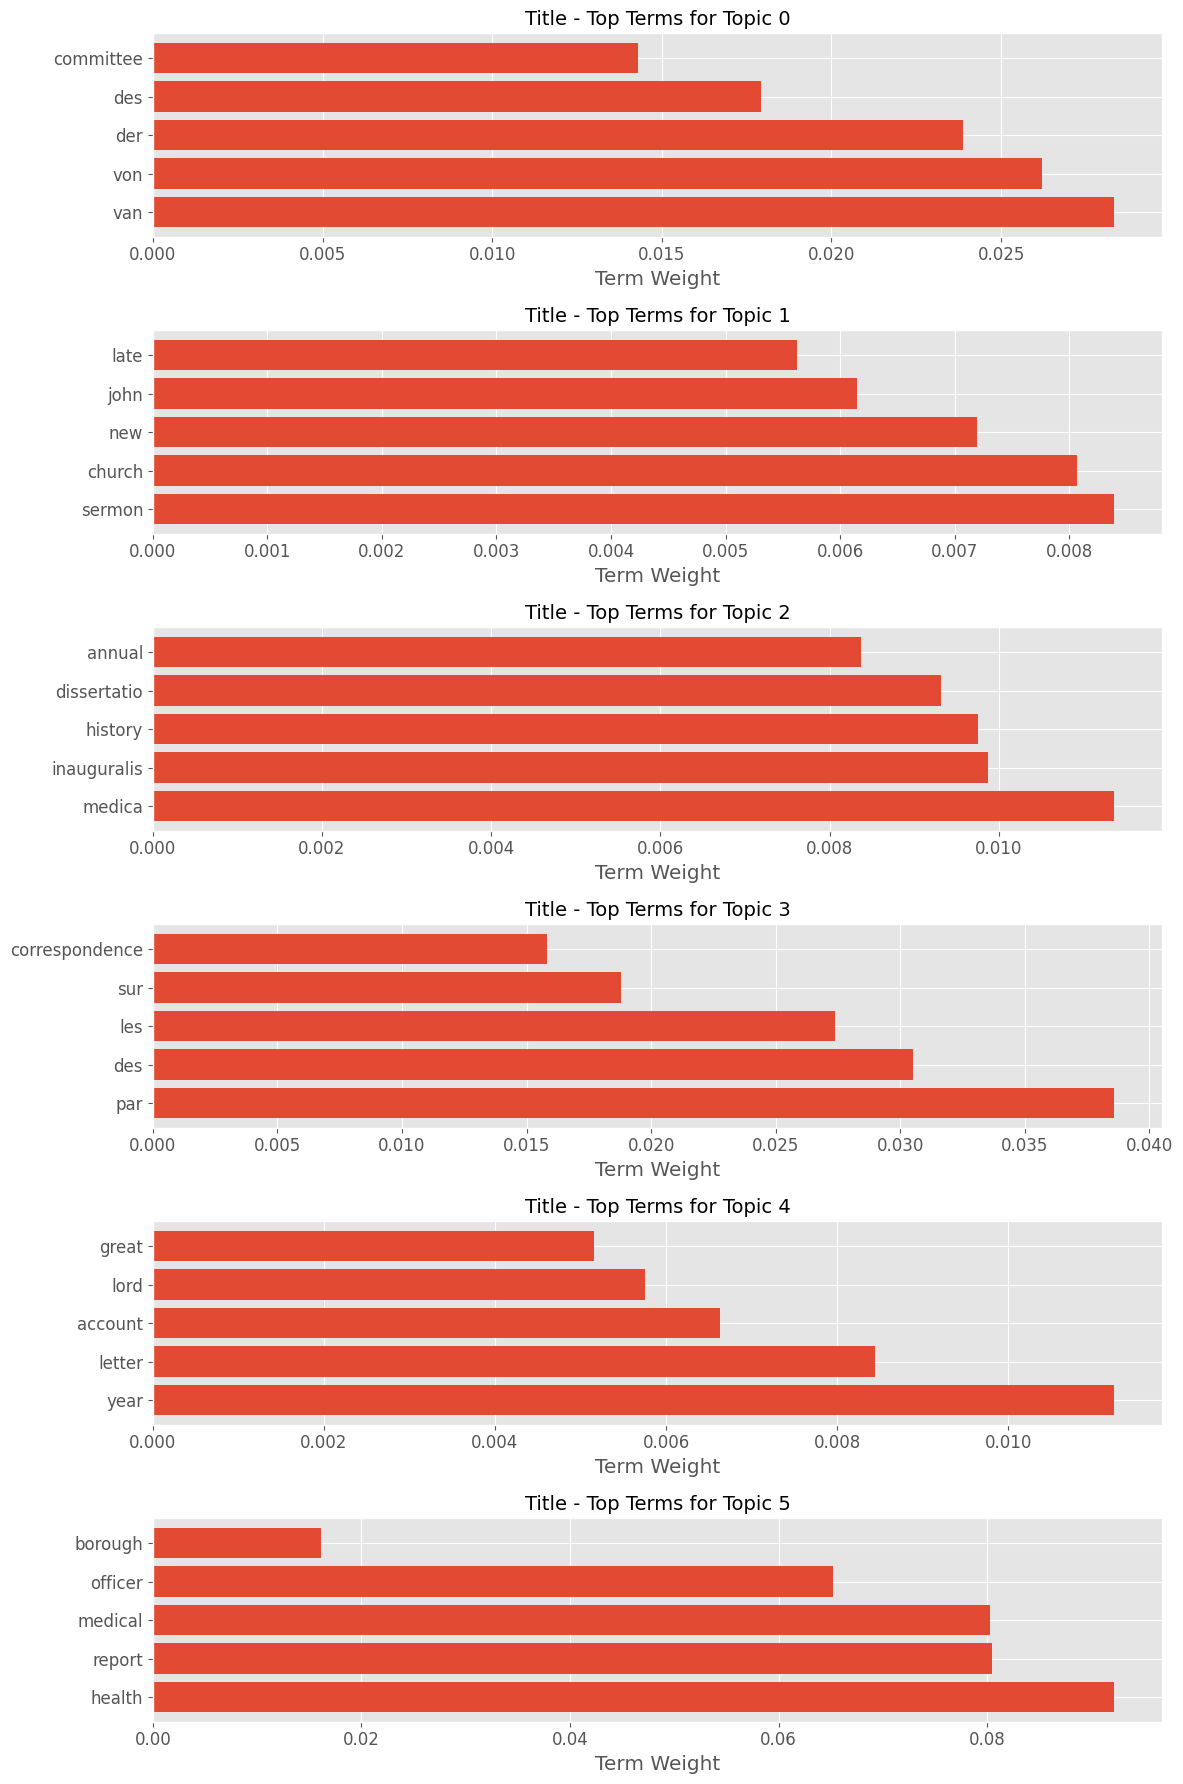

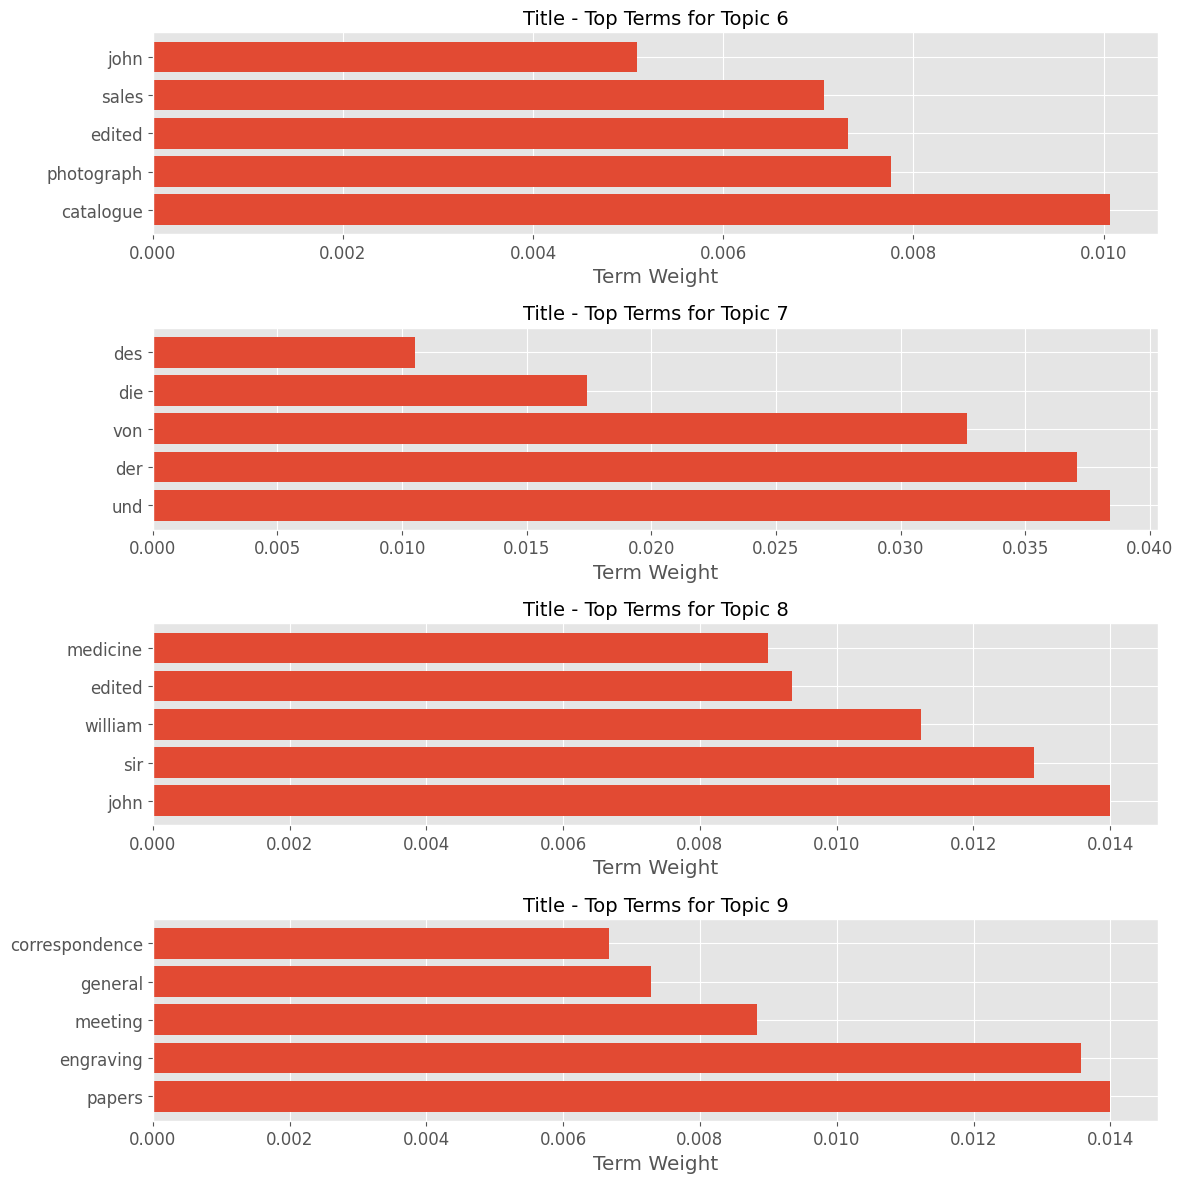

In [35]:
# Visualize topics and their most important terms
titles_topics_df = titles_topics_with_terms.toPandas()

# Create a function to plot top terms for each topic


def plot_topics(topics_df, field_name, num_terms=5):
    topics_to_plot = min(6, len(topics_df))  # Plot at most 6 topics at a time
    fig, axes = plt.subplots(topics_to_plot, 1, figsize=(12, 3*topics_to_plot))
    
    if topics_to_plot == 1:
        axes = [axes]  # Make sure axes is always a list
        
    for i, (ax, (_, row)) in enumerate(zip(axes, topics_df.iterrows())):
        # Get top terms and their weights
        terms = row['terms'][:num_terms]
        weights = row['termWeights'][:num_terms]
        
        # Create horizontal bar chart
        ax.barh(range(len(terms)), weights, align='center')
        ax.set_yticks(range(len(terms)))
        ax.set_yticklabels(terms)
        ax.set_title(
            f'{field_name} - Top Terms for Topic {row["topic"]}', fontsize=14)
        ax.set_xlabel('Term Weight')
    
    plt.tight_layout()
    plt.show()


# Plot the top topics
plot_topics(titles_topics_df, "Title")

# If there are more than 6 topics, plot the rest
if len(titles_topics_df) > 6:
    plot_topics(titles_topics_df.iloc[6:], "Title")

In [36]:
# Topic modeling using LDA (Latent Dirichlet Allocation)
from pyspark.ml.clustering import LDA

# Prepare the data for LDA - using the term frequency data from previous cell
# Filter out documents with empty word lists to avoid errors
lda_input = titles_term_freq_df.filter(F.size("clean_words") > 0)

# Number of topics to extract
num_topics = 10

# Create an LDA model
lda = LDA(k=num_topics, maxIter=10, featuresCol="term_freq")
descriptions_lda_model = lda.fit(lda_input)

# Get topics and their terms
descriptions_topics = descriptions_lda_model.describeTopics()
descriptions_topics.show(truncate=False)

# Convert topics to a more interpretable format
@F.udf(returnType=ArrayType(StringType()))
def map_term_indices_to_words(termIndices, vocabulary):
    return [vocabulary[idx] for idx in termIndices]


# Apply UDF to get terms for each topic
descriptions_topics_with_terms = descriptions_topics.withColumn(
    "terms", 
    map_term_indices_to_words(
        col("termIndices"), 
        F.array([F.lit(word) for word in descriptions_vocab])
    )
)

# Show topics with their terms
descriptions_topics_with_terms.select(
    "topic", "terms", "termWeights").show(
        truncate=100)

+-----+-----------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                              |termWeights                                                                                                                                                                                                                   |
+-----+-----------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[61, 5, 6, 7, 37, 99, 171, 9, 8, 22]     |[0.028326183701075553, 0.02620837360394466, 0.023867004702627266, 0.01791938079590248, 0.014293198594307234, 0.013406547469308888, 0

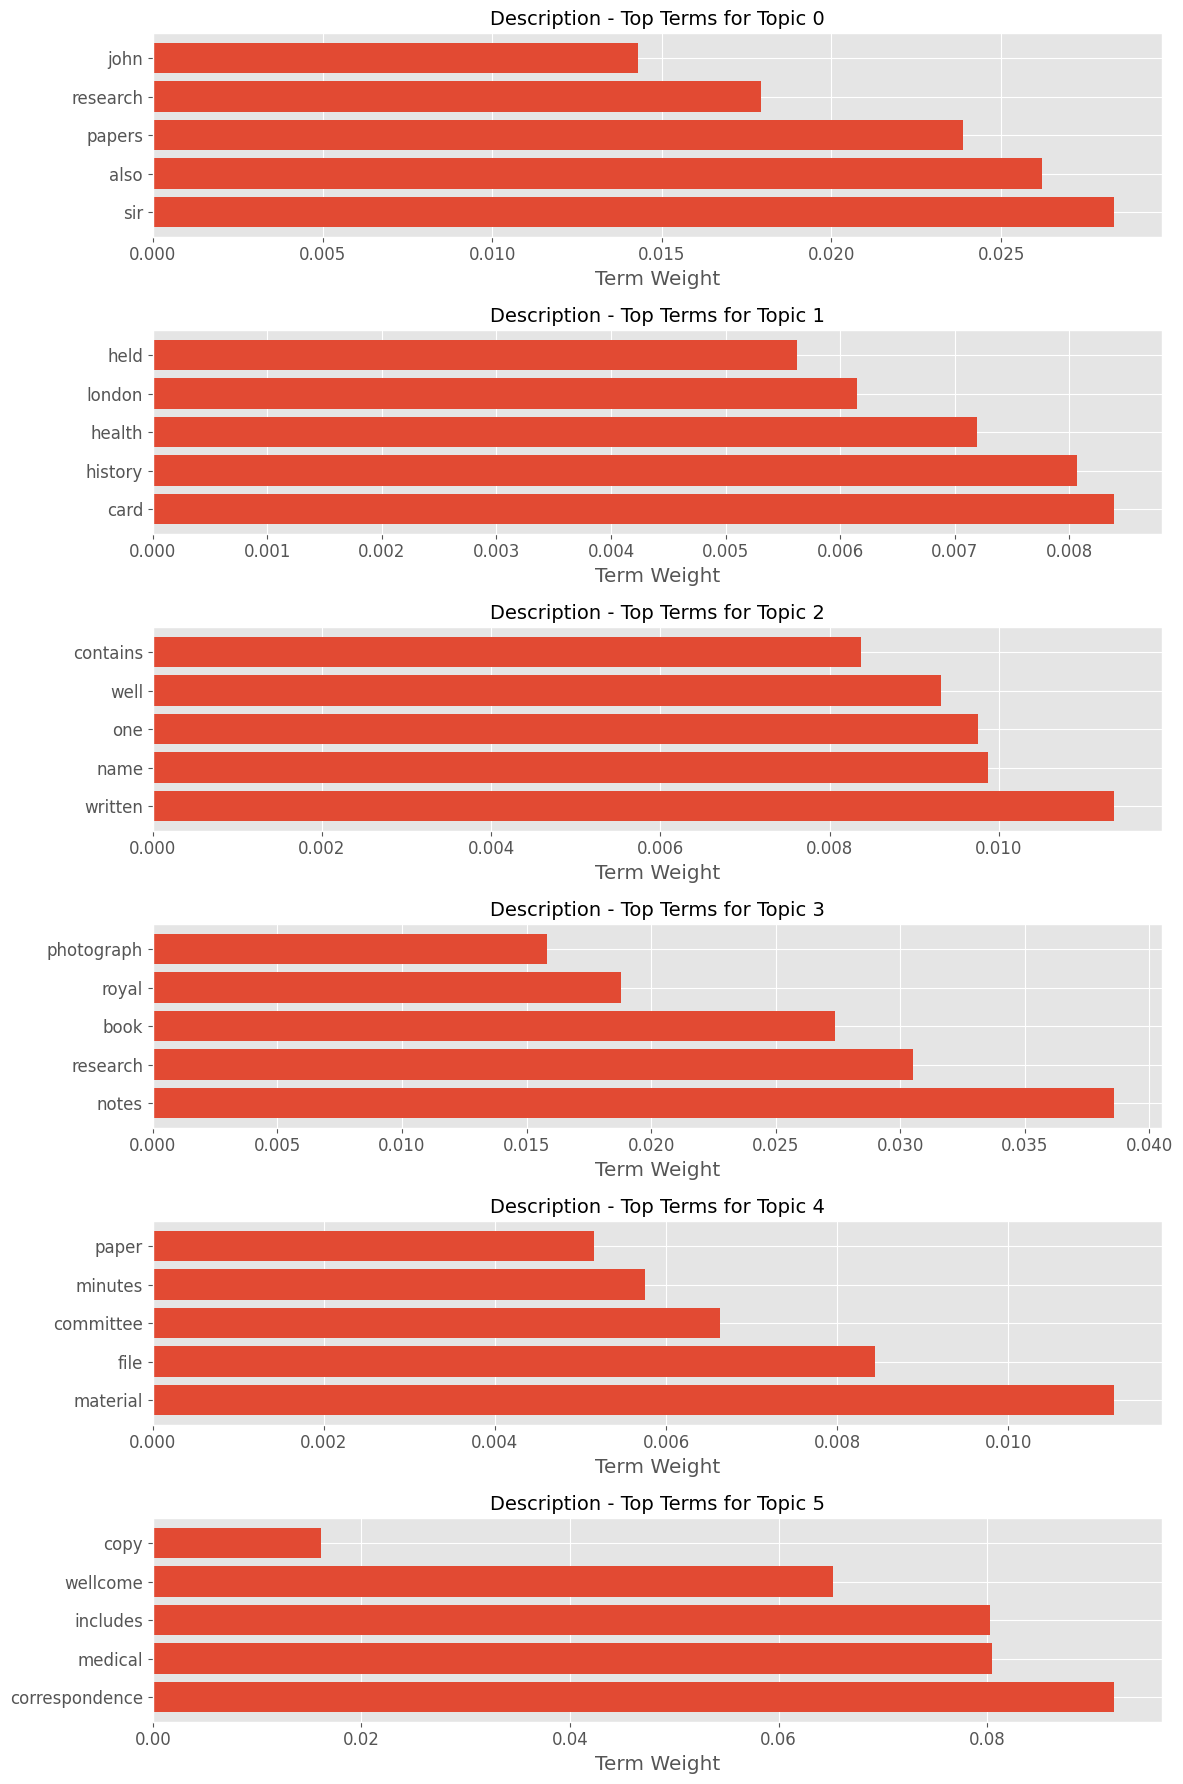

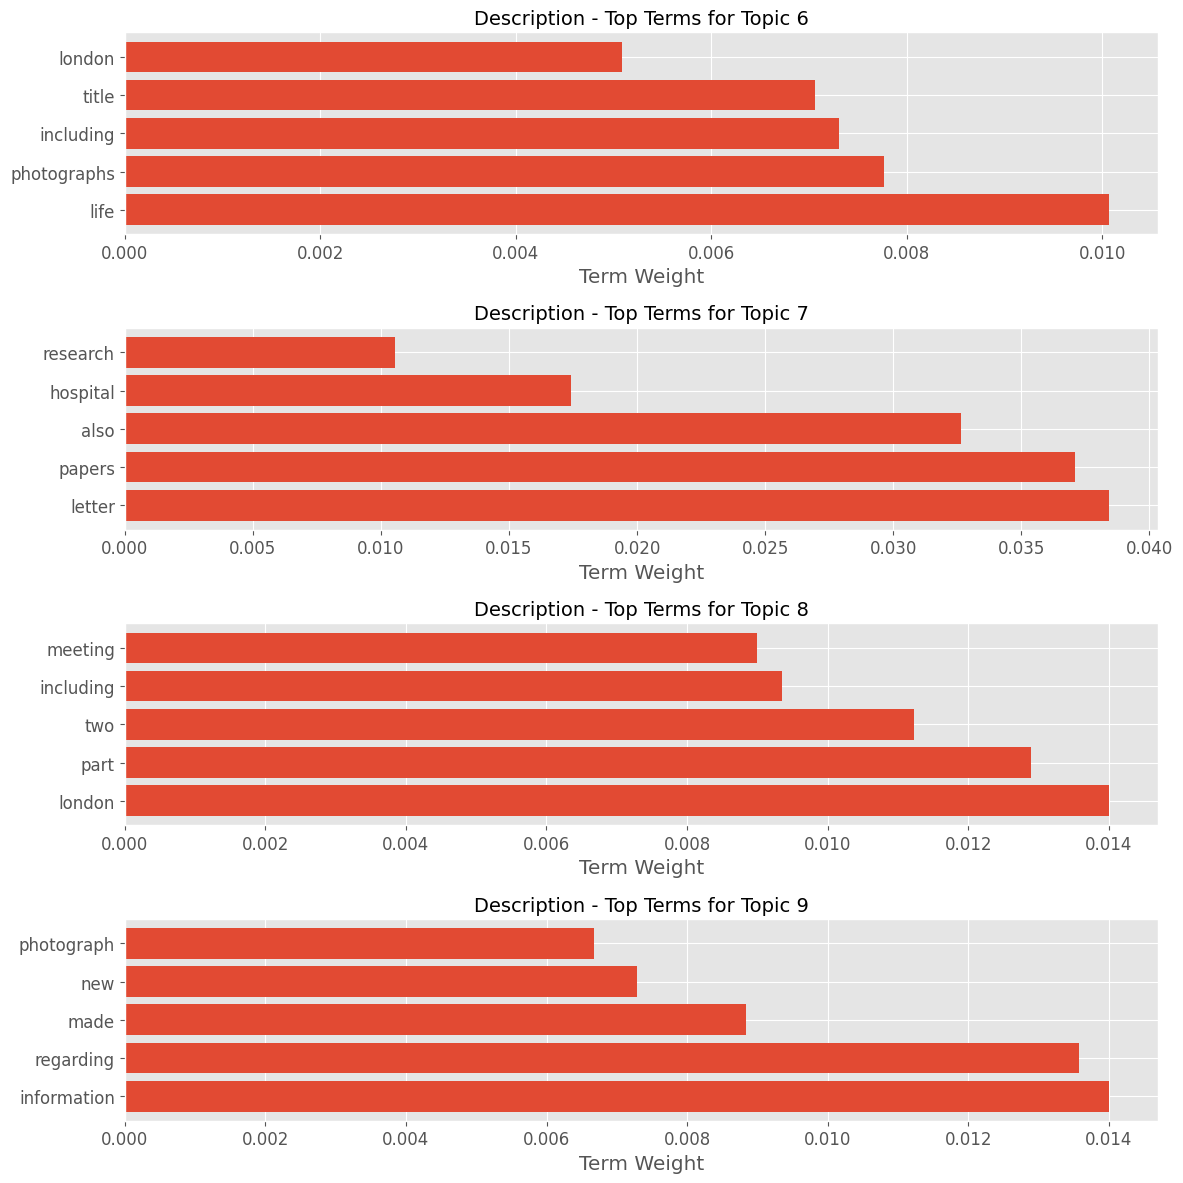

In [37]:
# Visualize topics and their most important terms
descriptions_topics_df = descriptions_topics_with_terms.toPandas()

# Create a function to plot top terms for each topic


def plot_topics(topics_df, field_name, num_terms=5):
    topics_to_plot = min(6, len(topics_df))  # Plot at most 6 topics at a time
    fig, axes = plt.subplots(topics_to_plot, 1, figsize=(12, 3*topics_to_plot))
    
    if topics_to_plot == 1:
        axes = [axes]  # Make sure axes is always a list
        
    for i, (ax, (_, row)) in enumerate(zip(axes, topics_df.iterrows())):
        # Get top terms and their weights
        terms = row['terms'][:num_terms]
        weights = row['termWeights'][:num_terms]
        
        # Create horizontal bar chart
        ax.barh(range(len(terms)), weights, align='center')
        ax.set_yticks(range(len(terms)))
        ax.set_yticklabels(terms)
        ax.set_title(
            f'{field_name} - Top Terms for Topic {
                row["topic"]}', fontsize=14)
        ax.set_xlabel('Term Weight')
    
    plt.tight_layout()
    plt.show()


# Plot the top topics
plot_topics(descriptions_topics_df, "Description")

# If there are more than 6 topics, plot the rest
if len(descriptions_topics_df) > 6:
    plot_topics(descriptions_topics_df.iloc[6:], "Description")

## Text Field Correlation Analysis

Let's explore relationships between different text fields.

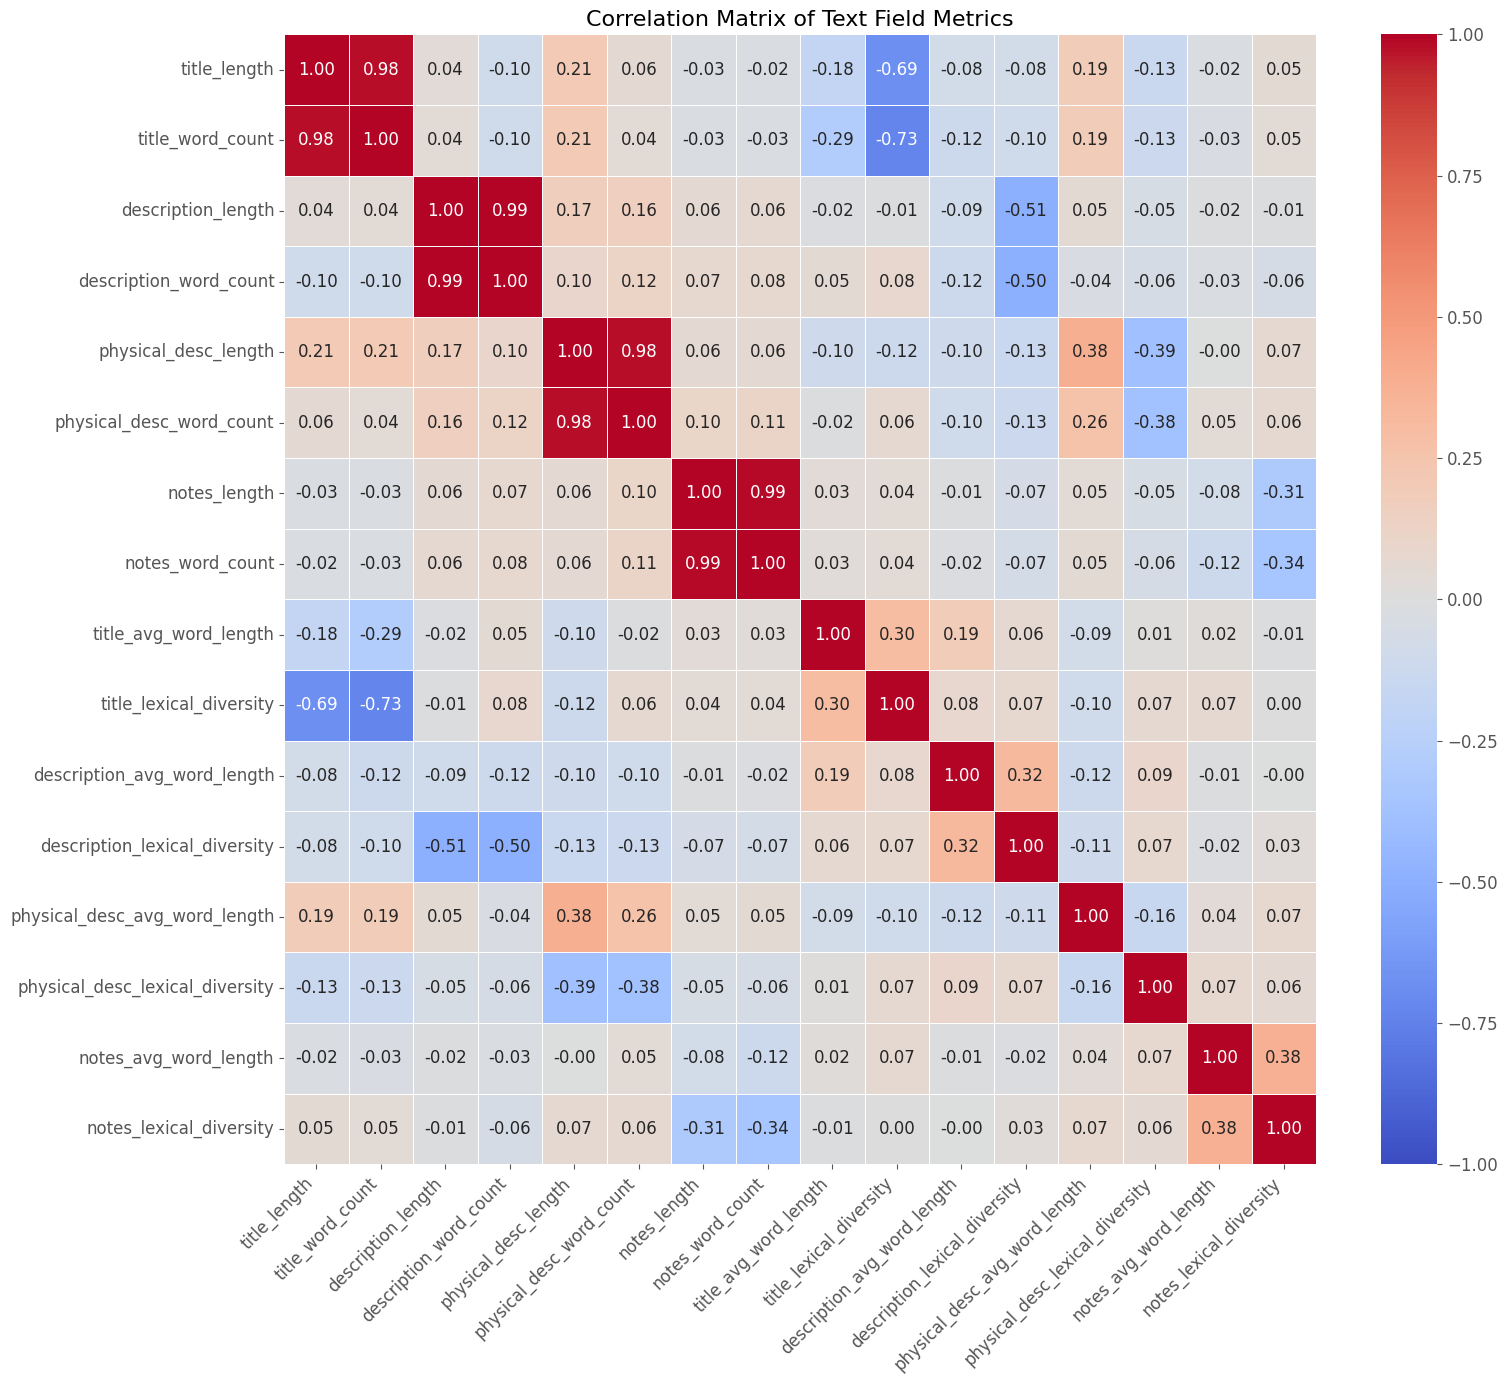

In [27]:
# Correlation analysis between text fields
# We'll create a correlation matrix of text length, complexity, and diversity metrics

# Prepare correlation data
corr_data = text_stats_pd.join(
    complexity_pd.set_index('id'),
    on='id', how='inner', rsuffix='_complexity'
)

# Select numerical columns for correlation
corr_columns = [
    'title_length', 'title_word_count',
    'description_length', 'description_word_count',
    'physical_desc_length', 'physical_desc_word_count',
    'notes_length', 'notes_word_count',
    'title_avg_word_length', 'title_lexical_diversity',
    'description_avg_word_length', 'description_lexical_diversity',
    'physical_desc_avg_word_length', 'physical_desc_lexical_diversity',
    'notes_avg_word_length', 'notes_lexical_diversity'
]

# Calculate correlation matrix
corr_matrix = corr_data[corr_columns].corr()

# Visualize correlation matrix as a heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix of Text Field Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Named Entity Recognition

Let's extract named entities (people, places, organizations, dates, etc.) from the text fields to understand what kinds of entities are mentioned in the collection.

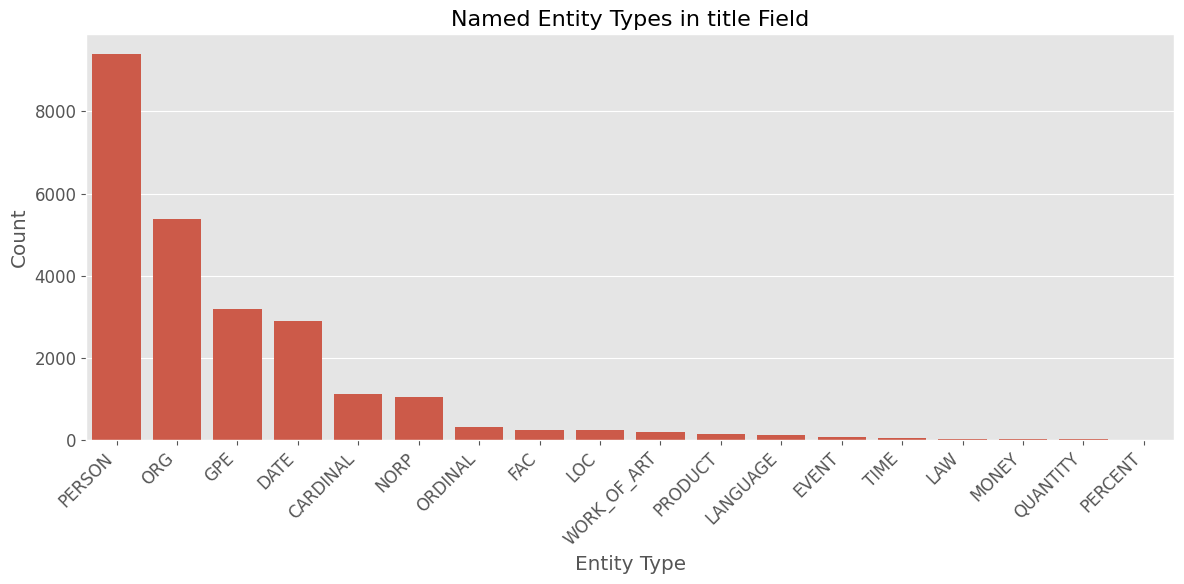


Most common ORG entities:
  - Parliament: 44
  - un: 25
  - Oxford: 23
  - the Church of England: 21
  - Faculté de médecine de Montpellier: 18

Most common PERSON entities:
  - Majesty: 53
  - John Thomson: 21
  - Viz: 13
  - Geschichte: 11
  - de la: 11

Most common CARDINAL entities:
  - two: 124
  - 2: 62
  - 1: 57
  - three: 51
  - one: 50

Most common GPE entities:
  - London: 125
  - England: 105
  - Esq: 92
  - Colour: 60
  - Ireland: 54

Most common DATE entities:
  - Annual: 60
  - annual: 44
  - the year: 30
  - 1947: 28
  - 1955: 26

Most common NORP entities:
  - British: 58
  - dans: 55
  - French: 48
  - Christian: 45
  - American: 35

Most common PRODUCT entities:
  - Ärzte: 6
  - Clergy: 3
  - Geo: 3
  - Notes: 3
  - Lives: 2

Most common FAC entities:
  - the Theatre-Royal: 20
  - the Theatre Royal: 12
  - the Hay-Market: 4
  - Florence Nightingale: 3
  - the Theatres-Royal: 3

Most common MONEY entities:
  - one penny: 1
  - 6 per cent: 1
  - twenty thousand and eig

In [34]:
# Named Entity Recognition using spaCy
# Note: You may need to install spaCy and download the English model:
# !pip install spacy
# !python -m spacy download en_core_web_sm

try:
    import spacy
    from collections import Counter
    import pandas as pd
    
    # Load spaCy model
    try:
        nlp = spacy.load('en_core_web_sm')
        
        # Sample some titles for NER (for performance reasons)
        sample_titles = df.filter(F.length('title') > 50) \
                               .select('title') \
                               .sample(False, 0.01) \
                               .toPandas()
        
        # Extract entities
        all_entities = []
        entity_texts = []
        entity_labels = []
        
        for desc in sample_titles['title']:
            if pd.notna(desc) and desc.strip():
                doc = nlp(desc[:10000])  # Limit text size for processing efficiency
                for ent in doc.ents:
                    all_entities.append((ent.text, ent.label_))
                    entity_texts.append(ent.text)
                    entity_labels.append(ent.label_)
        
        # Count entity types
        entity_type_counts = Counter([ent[1] for ent in all_entities])
        entity_counts_df = pd.DataFrame({
            'Entity Type': list(entity_type_counts.keys()),
            'Count': list(entity_type_counts.values())
        }).sort_values('Count', ascending=False)
        
        # Create entity DataFrame
        entities_df = pd.DataFrame({
            'text': entity_texts,
            'label': entity_labels
        })
        
        # Plot entity type distribution
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Entity Type', y='Count', data=entity_counts_df)
        plt.title('Named Entity Types in Title Field', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Show most common entities by type
        most_common_entities = {}
        for entity_type in entities_df['label'].unique():
            entities_of_type = entities_df[entities_df['label'] == entity_type]['text']
            most_common = Counter(entities_of_type).most_common(5)
            if most_common:
                most_common_entities[entity_type] = most_common
        
        for entity_type, common_entities in most_common_entities.items():
            print(f"\nMost common {entity_type} entities:")
            for entity, count in common_entities:
                print(f"  - {entity}: {count}")
    except Exception as e:
        print(f"Error loading spaCy model: {e}")
        print("Please install the English model with: python -m spacy download en_core_web_sm")
        
except ImportError:
    print("spaCy is not installed. Install using: pip install spacy")

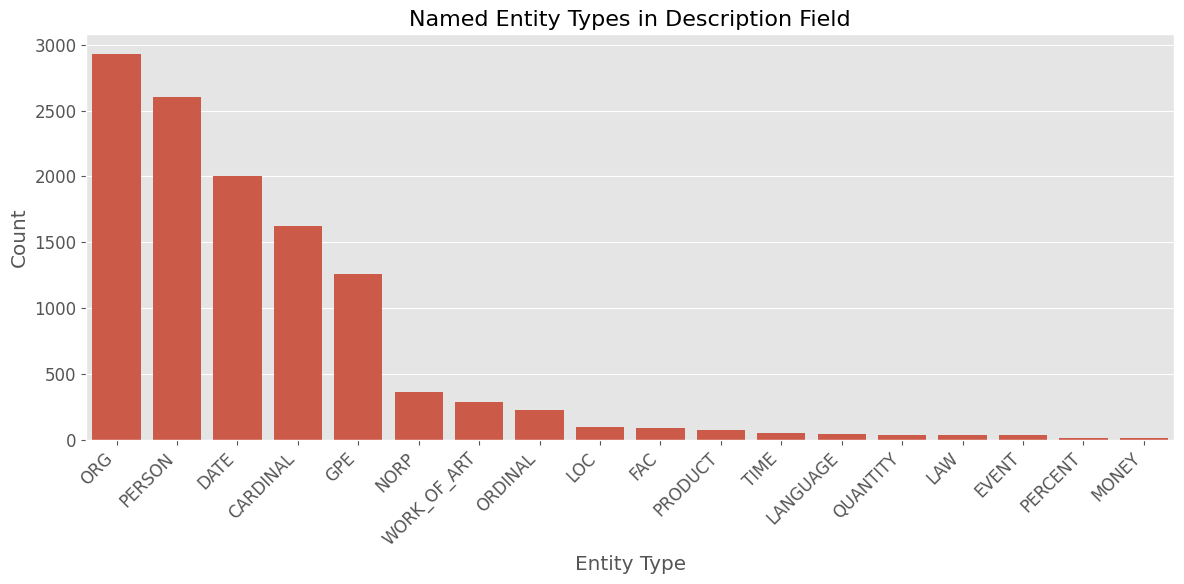


Most common ORG entities:
  - the Wellcome Historical Medical Museum: 35
  - the MRC Biophysics Research Unit/Department of Biophysics, King's College London: 25
  - Wellcome Collection: 24
  - Wellcome: 20
  - J B S Haldane: 18

Most common DATE entities:
  - 1965: 14
  - annual: 14
  - 1977: 13
  - today: 11
  - 1968: 9

Most common PERSON entities:
  - Edward Adamson: 15
  - Tabloid: 13
  - Dartford: 12
  - Penrose: 10
  - Audrey Amiss: 9

Most common WORK_OF_ART entities:
  - Comparative Study of Mining Systems Composite Cutting Longwalls: 6
  - Secretarial Notes" of Special Board Meeting: 3
  - L S Penrose: 3
  - F: 3
  - Bible: 2

Most common CARDINAL entities:
  - two: 87
  - one: 83
  - 2: 78
  - 1: 78
  - three: 50

Most common GPE entities:
  - London: 116
  - Haldane: 39
  - Paris: 27
  - New York: 21
  - UK: 19

Most common LOC entities:
  - Europe: 9
  - Africa: 6
  - Asia: 5
  - the South East: 4
  - West: 4

Most common LAW entities:
  - Copy 1: 2
  - Version 25: 2
  - 

In [ ]:
# Named Entity Recognition using spaCy
# Note: You may need to install spaCy and download the English model:
# !pip install spacy
# !python -m spacy download en_core_web_sm

try:
    import spacy
    from collections import Counter
    import pandas as pd
    
    # Load spaCy model
    try:
        nlp = spacy.load('en_core_web_sm')
        
        # Sample some descriptions for NER (for performance reasons)
        sample_descriptions = df.filter(F.length('description') > 50) \
                               .select('description') \
                               .sample(False, 0.01) \
                               .toPandas()
        
        # Extract entities
        all_entities = []
        entity_texts = []
        entity_labels = []
        
        for desc in sample_descriptions['description']:
            if pd.notna(desc) and desc.strip():
                doc = nlp(desc[:10000])  # Limit text size for processing efficiency
                for ent in doc.ents:
                    all_entities.append((ent.text, ent.label_))
                    entity_texts.append(ent.text)
                    entity_labels.append(ent.label_)
        
        # Count entity types
        entity_type_counts = Counter([ent[1] for ent in all_entities])
        entity_counts_df = pd.DataFrame({
            'Entity Type': list(entity_type_counts.keys()),
            'Count': list(entity_type_counts.values())
        }).sort_values('Count', ascending=False)
        
        # Create entity DataFrame
        entities_df = pd.DataFrame({
            'text': entity_texts,
            'label': entity_labels
        })
        
        # Plot entity type distribution
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Entity Type', y='Count', data=entity_counts_df)
        plt.title('Named Entity Types in Description Field', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Show most common entities by type
        most_common_entities = {}
        for entity_type in entities_df['label'].unique():
            entities_of_type = entities_df[entities_df['label'] == entity_type]['text']
            most_common = Counter(entities_of_type).most_common(5)
            if most_common:
                most_common_entities[entity_type] = most_common
        
        for entity_type, common_entities in most_common_entities.items():
            print(f"\nMost common {entity_type} entities:")
            for entity, count in common_entities:
                print(f"  - {entity}: {count}")
    except Exception as e:
        print(f"Error loading spaCy model: {e}")
        print("Please install the English model with: python -m spacy download en_core_web_sm")
        
except ImportError:
    print("spaCy is not installed. Install using: pip install spacy")

## Novel Text Characterization Approaches

Let's explore some innovative approaches to characterize the text content:


### Sentiment Polarity  
TextBlob’s polarity score also comes from the Pattern library’s lexicon‐based, rule‐driven sentiment analyzer. Here’s the gist of how it arrives at a single polarity value for a piece of text:

1. **Lexicon of Polarity Weights**  
   Pattern includes a dictionary mapping several thousand English words/phrases to a polarity weight between –1.0 (maximally negative) and +1.0 (maximally positive). For example:  
   - “good” → +0.7  
   - “terrible” → –0.9  
   - “amazing” → +0.8  
   - “boring” → –0.5  

2. **Tokenization and Lookup**  
   The text is split into tokens (words and multi-word expressions). Each token that appears in the lexicon contributes its weight; tokens not found are treated as neutral (i.e. weight = 0).

3. **Handling Intensifiers and Negations**  
   Before simply averaging, Pattern applies a small set of linguistic rules to adjust weights based on context:
   - **Intensifiers** (“very,” “extremely,” “absolutely”) scale the weight of the next adjective or adverb upward.
   - **Diminishers** (“slightly,” “somewhat”) scale it downward.
   - **Negations** (“not,” “never,” “no”) flip the sign of a nearby sentiment word or reduce its magnitude.

   For example:
   - “very good” → +0.7 × 1.5 ≈ +1.05 (capped at +1.0)
   - “not good” → –0.7  

4. **Aggregation into One Score**  
   After adjustments, Pattern sums up all the polarity contributions and then divides by the number of contributing tokens (or clauses), yielding an **average polarity** in the range [–1.0, +1.0]. Formally:  
   \[
     \text{polarity(text)}
     = \frac{\sum_{i=1}^{N} \text{adjusted\_polarity}(w_i)}
            {N}
   \]
   where \(w_i\) are the tokens found in the sentiment lexicon after any intensifier/negation adjustments.

5. **Clause-Level Bonus**  
   For longer texts, Pattern actually breaks the input into clauses (by punctuation) and computes clause‐level polarities before averaging them, so that very long sentences don’t drown out the sentiment of a short but strongly worded clause.


### TextBlob’s subjectivity score

TextBlob’s subjectivity score comes from the underlying Pattern library’s lexicon-based analyzer. Here’s roughly how it works:

1. **Lexicon of Subjectivity Weights**  
   Pattern ships with a dictionary of several thousand English words and phrases, each annotated with two numbers:  
   - **Polarity** ∈ [–1.0, +1.0]  
   - **Subjectivity** ∈ [0.0, 1.0]  

   A subjectivity weight of 0.0 means the word is purely factual (“kilogram,” “January,” “bronze”), whereas 1.0 indicates a maximally opinionated term (“love,” “terrible,” “should”).

2. **Token‐Level Scoring**  
   When you call `TextBlob(text).sentiment`, the Pattern analyzer:  
   - **Tokenizes** the text into words/phrases.  
   - **Looks up** each token in its lexicon.  
   - **Ignores** tokens not in the lexicon (they’re treated as objective).

3. **Aggregating to a Single Score**  
   It then computes the **average** of all the subjectivity weights for tokens **that do appear** in the lexicon. Formally:  
   \[
     \text{subjectivity(text)}
     = \frac{\sum_{i=1}^{N} \text{subjectivity}(w_i)}
            {N}
   \]
   where \(w_i\) ranges over the \(N\) tokens found in the lexicon.  
   - If **no** tokens are in the lexicon, it returns 0.0 (completely objective).  
   - A score **close to 0.0** means almost all words are factual.  
   - A score **close to 1.0** means you’ve used mostly opinionated terms.

4. **Examples**  
   - “Made of bronze, 10 cm tall.” → almost every word is inanimate/factual → subjectivity ≈ 0.0  
   - “I absolutely love how vibrant this looks!” → words like “absolutely,” “love,” “vibrant” each carry high subjectivity → subjectivity ≈ 0.8–1.0  

So when you see a boxplot of subjectivity scores by field, you’re really seeing how many—and how strongly—opinionated words show up in each text type.

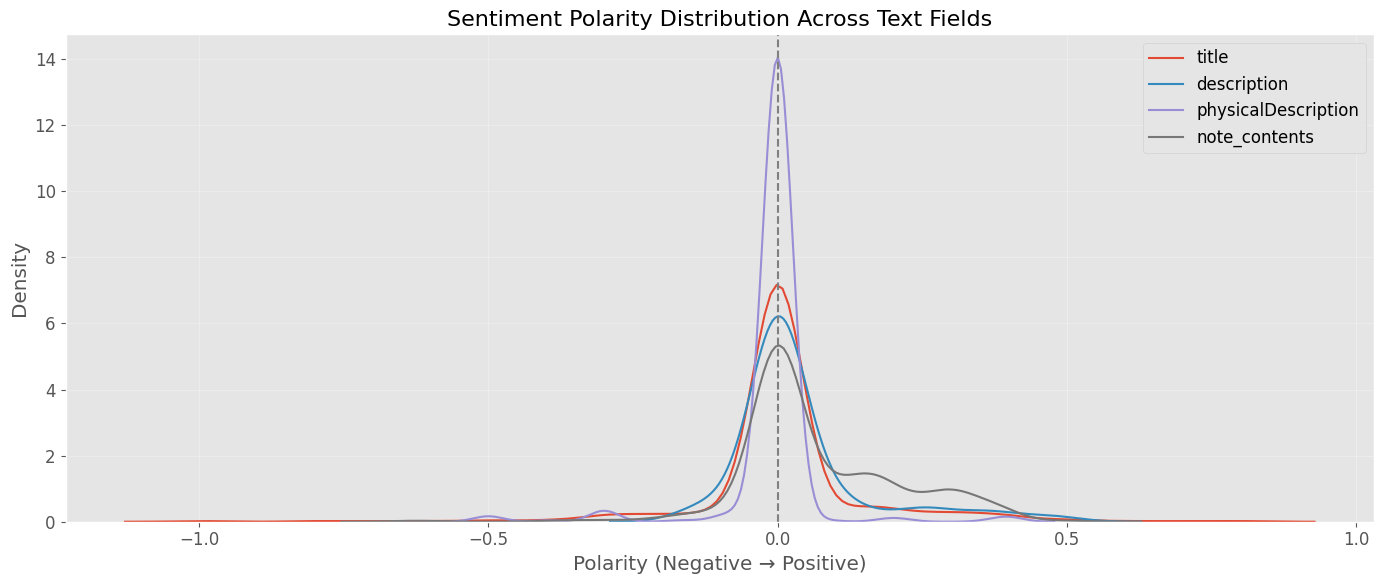

/var/folders/zl/fybgws9n4d10nrybrb5483m80000gn/T/ipykernel_60759/2005664609.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data for field, data in subj_data.items()], labels=list(subj_data.keys()))


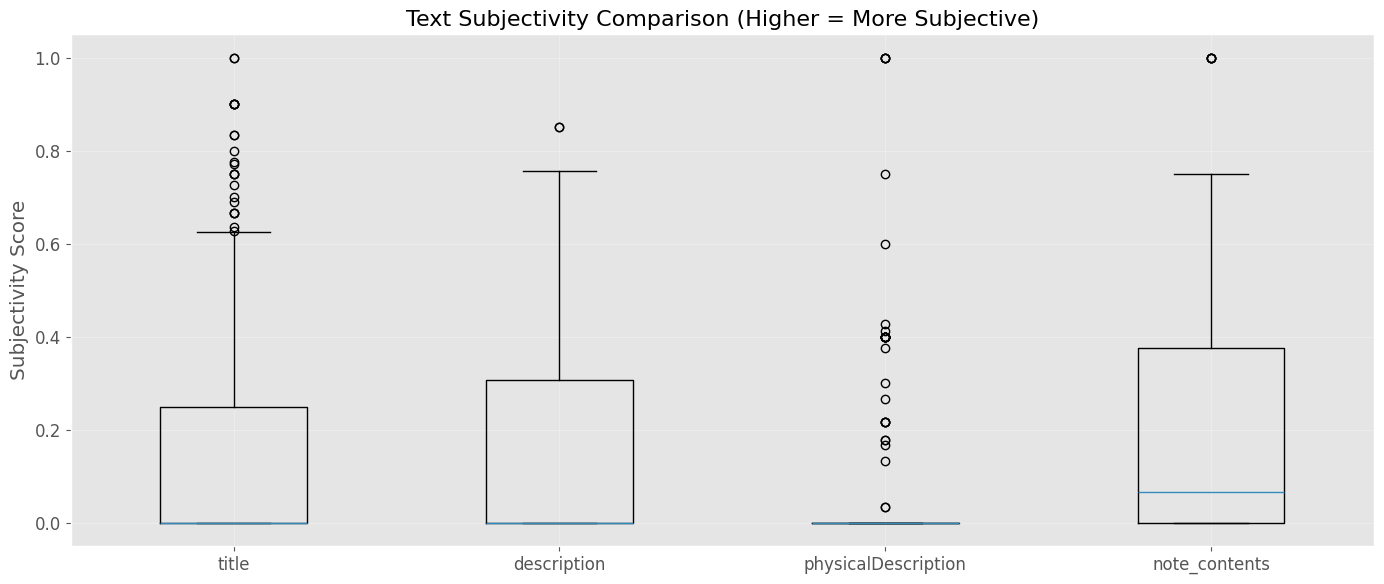

In [33]:
# 1. Sentiment Analysis - Exploring emotional tone of text fields
try:
    from textblob import TextBlob
    import pandas as pd
    import numpy as np
    
    # Function to calculate sentiment polarity and subjectivity
    def get_sentiment(text):
        if pd.isna(text) or text.strip() == '':
            return (np.nan, np.nan)  # Return NaN for empty text
        blob = TextBlob(text)
        return (blob.sentiment.polarity, blob.sentiment.subjectivity)
    
    # Sample some descriptions for sentiment analysis
    sample_data = df.select(
        'id', 'title', 'description', 'physicalDescription', 'note_contents'
    ).limit(500).toPandas()
    
    # Calculate sentiment scores for each field
    sentiment_data = []
    for _, row in sample_data.iterrows():
        record = {'id': row['id']}
        
        # Process each text field
        for field in ['title', 'description', 'physicalDescription', 'note_contents']:
            if pd.notna(row[field]) and row[field].strip():
                polarity, subjectivity = get_sentiment(row[field])
                record[f'{field}_polarity'] = polarity
                record[f'{field}_subjectivity'] = subjectivity
                
        sentiment_data.append(record)
    
    # Create DataFrame with sentiment scores
    sentiment_df = pd.DataFrame(sentiment_data)
    
    # Plot sentiment polarity distribution across different fields
    plt.figure(figsize=(14, 6))
    for field in ['title', 'description', 'physicalDescription', 'note_contents']:
        col = f'{field}_polarity'
        if col in sentiment_df.columns:
            sns.kdeplot(sentiment_df[col].dropna(), label=field)
    
    plt.title('Sentiment Polarity Distribution Across Text Fields', fontsize=16)
    plt.xlabel('Polarity (Negative → Positive)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Plot subjectivity comparison boxplot
    plt.figure(figsize=(14, 6))
    subj_data = {
        field: sentiment_df[f'{field}_subjectivity'].dropna() 
        for field in ['title', 'description', 'physicalDescription', 'note_contents'] 
        if f'{field}_subjectivity' in sentiment_df.columns
    }
    plt.boxplot([data for field, data in subj_data.items()], labels=list(subj_data.keys()))
    plt.title('Text Subjectivity Comparison (Higher = More Subjective)', fontsize=16)
    plt.ylabel('Subjectivity Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("TextBlob not installed. Install with: pip install textblob")

## Flesch–Kincaid Reading Grade Level

The **Flesch–Kincaid Reading Grade Level** is a readability test designed to indicate how difficult a passage in English is to understand. Unlike its sibling metric, the Flesch Reading Ease score (which yields a 0–100 score), the Grade Level formula produces a U.S. school‐grade level. For instance, a score of 8.0 means that an eighth grader should be able to understand the text.

---

### 1. Purpose and Use Cases

- **Assessing Educational Materials**  
  Helps educators match texts to students’ reading abilities.  
- **Plain‐Language Initiatives**  
  Government agencies and businesses use it to ensure documents are accessible to a broad audience.  
- **Content Creation and SEO**  
  Writers and editors gauge whether blog posts, manuals, or web content are appropriately targeted.

---

### 2. The Formula

The Flesch–Kincaid Grade Level (FKGL) is computed as:

$$
\mathrm{FKGL} \;=\;
0.39 \times \Bigl(\tfrac{\text{total words}}{\text{total sentences}}\Bigr)
\;+\;
11.8 \times \Bigl(\tfrac{\text{total syllables}}{\text{total words}}\Bigr)
\;-\;
15.59
$$

- **total words**: The number of words in the passage.  
- **total sentences**: The number of sentences.  
- **total syllables**: The number of syllables across all words.  

> **Example calculation**  
> A 100-word passage with 5 sentences (20 words/sentence avg.) and 150 syllables (1.5 syllables/word avg.) would score:  
> $$
> \mathrm{FKGL} = 0.39 \times 20 + 11.8 \times 1.5 - 15.59 = 7.8 + 17.7 - 15.59 \approx 9.91
> $$  
> → ~10th-grade level.

---

### 3. Interpreting the Score

| FKGL Score | Interpretation            |
|------------|---------------------------|
| 0.0–1.0    | Kindergarten–1st grade    |
| 2.0–3.0    | 2nd–3rd grade             |
| …          | …                         |
| 8.0–9.0    | 8th–9th grade             |
| 12.0–13.0  | College freshman          |

- **Lower scores** mean easier texts.  
- **Higher scores** indicate more complex material (longer sentences, more syllables).

---

### 4. Strengths and Limitations

**Strengths**  
- Quantitative and objective.  
- Easy to compute (built into many word‐processors).

**Limitations**  
- **Surface‐level**: Ignores semantics, organization, reader background.  
- **Language‐specific**: Tailored to English; syllable counts can be tricky (e.g., “queue,” “either”).  
- **Doesn’t capture visuals**: Charts, images, and layout can affect comprehensibility but aren’t measured.

---

### 5. Practical Tips for Writers

- **Shorten sentences**: Aim for 15–20 words on average.  
- **Choose simpler words**: Favor one‐ or two-syllable words where possible.  
- **Use active voice**: Tends to reduce complexity and sentence length.  
- **Break up text**: Bullet lists, subheadings, and white space all improve real-world readability beyond what the formula captures.

---

**In sum**, the Flesch–Kincaid Reading Grade Level gives you a quick, numerical gauge of text complexity—expressed as the U.S. school grade needed to comfortably understand the passage. It’s a handy guide for tailoring your writing to your audience, but it should be complemented with human judgment about clarity, context, and engagement.

,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score,text_standard
count,2757.000000,2757.000000,2757.000000,2757.000000,2757.000000,2757.000000,2757.000000
mean,44.747845,11.378818,4.886108,12.825582,14.626732,12.541795,12.114980
std,25.751704,4.923590,6.590982,5.067592,6.168445,3.172227,5.076503
min,-96.890000,0.100000,0.000000,-10.310000,-4.300000,0.100000,0.000000
25%,29.180000,8.000000,0.000000,9.630000,10.400000,10.470000,9.000000
50%,47.460000,10.800000,0.000000,12.360000,13.800000,11.980000,12.000000
75%,63.020000,14.200000,11.200000,15.740000,17.900000,14.000000,15.000000
max,106.670000,29.800000,26.000000,65.790000,66.800000,40.630000,36.000000


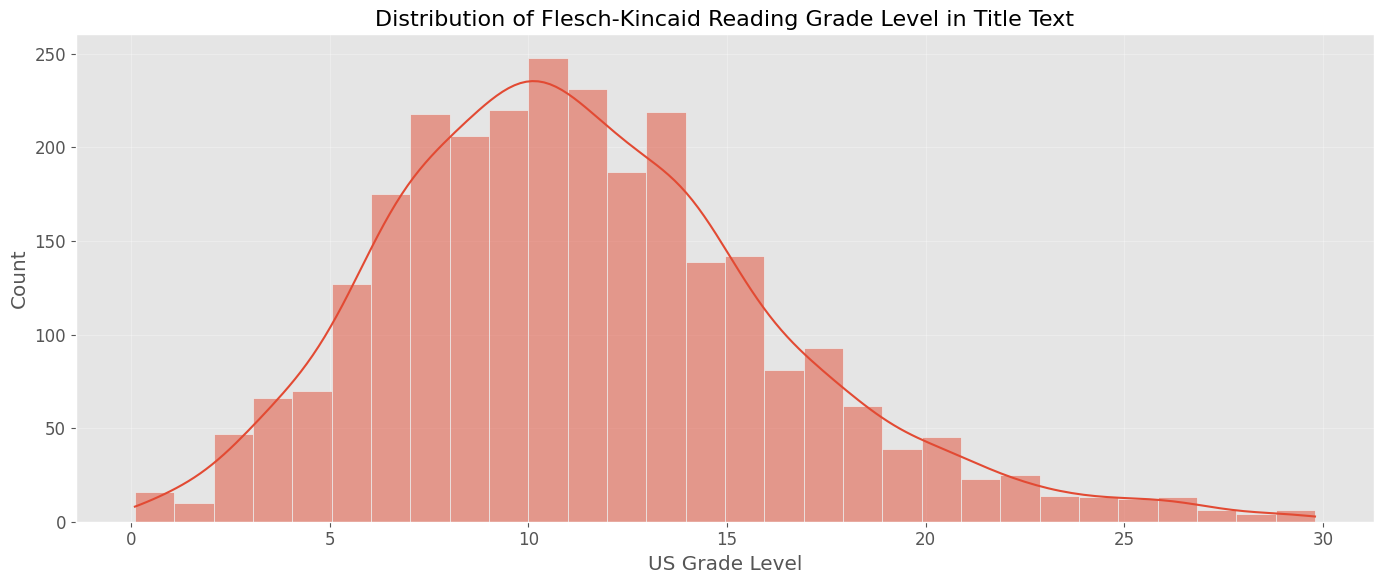

In [60]:
# 2. Text Readability and Complexity Metrics
try:
    import textstat
    
    # Sample data for readability analysis
    title_readability_sample = df.filter(F.length('title') > 100).select('id', 'description').sample(False, 0.1).toPandas()
    
    # Calculate readability scores
    title_readability_data = []
    for _, row in title_readability_sample.iterrows():
        if pd.notna(row['description']) and len(row['description'].strip()) > 0:
            text = row['description']
            title_readability_data.append({
                'id': row['id'],
                'flesch_reading_ease': textstat.flesch_reading_ease(text),
                'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
                'smog_index': textstat.smog_index(text),
                'coleman_liau_index': textstat.coleman_liau_index(text),
                'automated_readability_index': textstat.automated_readability_index(text),
                'dale_chall_readability_score': textstat.dale_chall_readability_score(text),
                'text_standard': textstat.text_standard(text, float_output=True)
            })
    
    # Create DataFrame with readability metrics
    title_readability_df = pd.DataFrame(title_readability_data)

    # Remove outliers
    title_readability_df = title_readability_df[
        (title_readability_df['flesch_kincaid_grade'] >= 0) &
        (title_readability_df['flesch_kincaid_grade'] <= 30)
    ]
    
    # Calculate summary statistics
    title_readability_stats = title_readability_df.describe()
    display(title_readability_stats)
    
    # Plot distribution of reading level
    plt.figure(figsize=(14, 6))
    sns.histplot(
        title_readability_df['flesch_kincaid_grade'].dropna(),
        kde=True, bins=30)
    plt.title(
        'Distribution of Flesch-Kincaid Reading Grade Level in Title Text',
        fontsize=16)
    plt.xlabel('US Grade Level')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("TextStat not installed. Install with: pip install textstat")

,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score,text_standard
count,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000
mean,38.910673,12.485993,5.625922,13.693175,15.233105,12.545248,13.218692
std,23.029354,4.587259,6.666802,4.388650,5.933743,2.495455,4.567440
min,-62.030000,0.500000,0.000000,-2.760000,-0.900000,5.910000,0.000000
25%,24.950000,9.200000,0.000000,10.740000,11.200000,10.850000,10.000000
50%,40.550000,12.000000,0.000000,13.230000,14.300000,12.230000,13.000000
75%,55.240000,15.100000,12.000000,16.190000,18.300000,13.880000,16.000000
max,111.070000,29.900000,28.500000,50.930000,73.900000,36.730000,43.000000


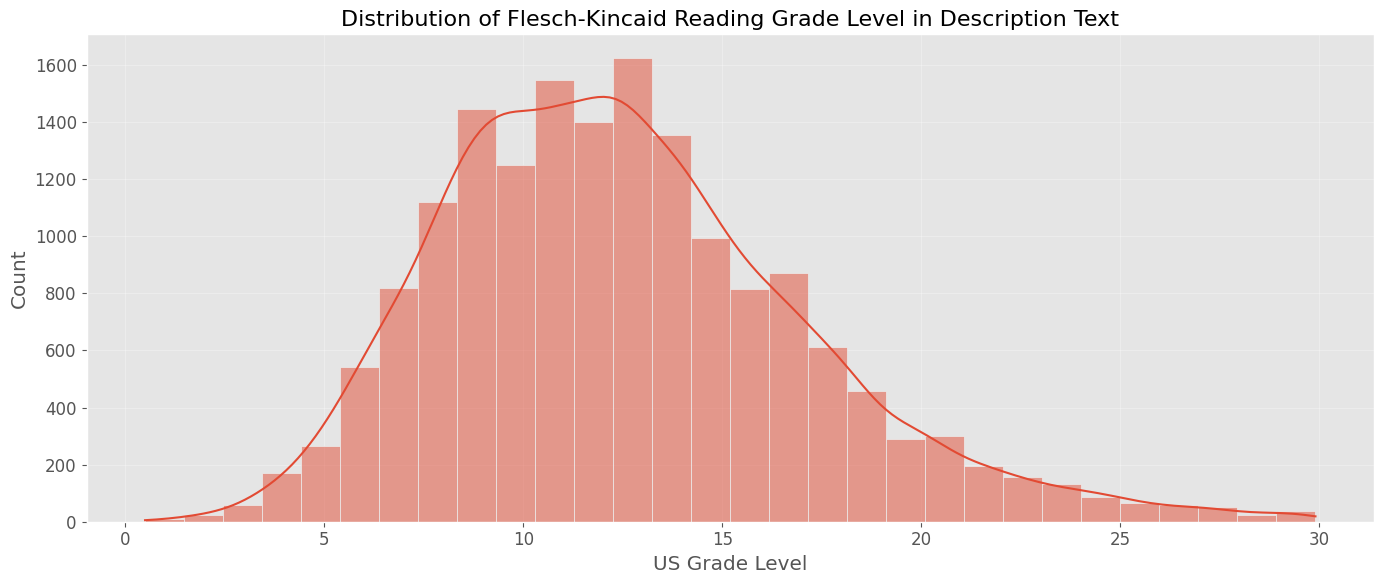

In [61]:
# 2. Text Readability and Complexity Metrics
try:
    import textstat
    
    # Sample data for readability analysis
    description_readability_sample = df.filter(F.length('description') > 100).select('id', 'description').sample(False, 0.11).toPandas()
    
    # Calculate readability scores
    description_readability_data = []
    for _, row in description_readability_sample.iterrows():
        if pd.notna(row['description']) and len(row['description'].strip()) > 0:
            text = row['description']
            description_readability_data.append({
                'id': row['id'],
                'flesch_reading_ease': textstat.flesch_reading_ease(text),
                'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
                'smog_index': textstat.smog_index(text),
                'coleman_liau_index': textstat.coleman_liau_index(text),
                'automated_readability_index': textstat.automated_readability_index(text),
                'dale_chall_readability_score': textstat.dale_chall_readability_score(text),
                'text_standard': textstat.text_standard(text, float_output=True)
            })
    
    # Create DataFrame with readability metrics
    description_readability_df = pd.DataFrame(description_readability_data)

    # Remove outliers
    description_readability_df = description_readability_df[
        (description_readability_df['flesch_kincaid_grade'] > 0) &
        (description_readability_df['flesch_kincaid_grade'] < 30)
    ]
    
    # Calculate summary statistics
    description_readability_stats = description_readability_df.describe()
    display(description_readability_stats)
    
    # Plot distribution of reading level
    plt.figure(figsize=(14, 6))
    sns.histplot(
        description_readability_df['flesch_kincaid_grade'].dropna(),
        kde=True, bins=30)
    plt.title('Distribution of Flesch-Kincaid Reading Grade Level in Description Text', fontsize=16)
    plt.xlabel('US Grade Level')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("TextStat not installed. Install with: pip install textstat")

## Text Clustering and Collection Segmentation

Let's segment the collection based on text content to identify natural groupings.

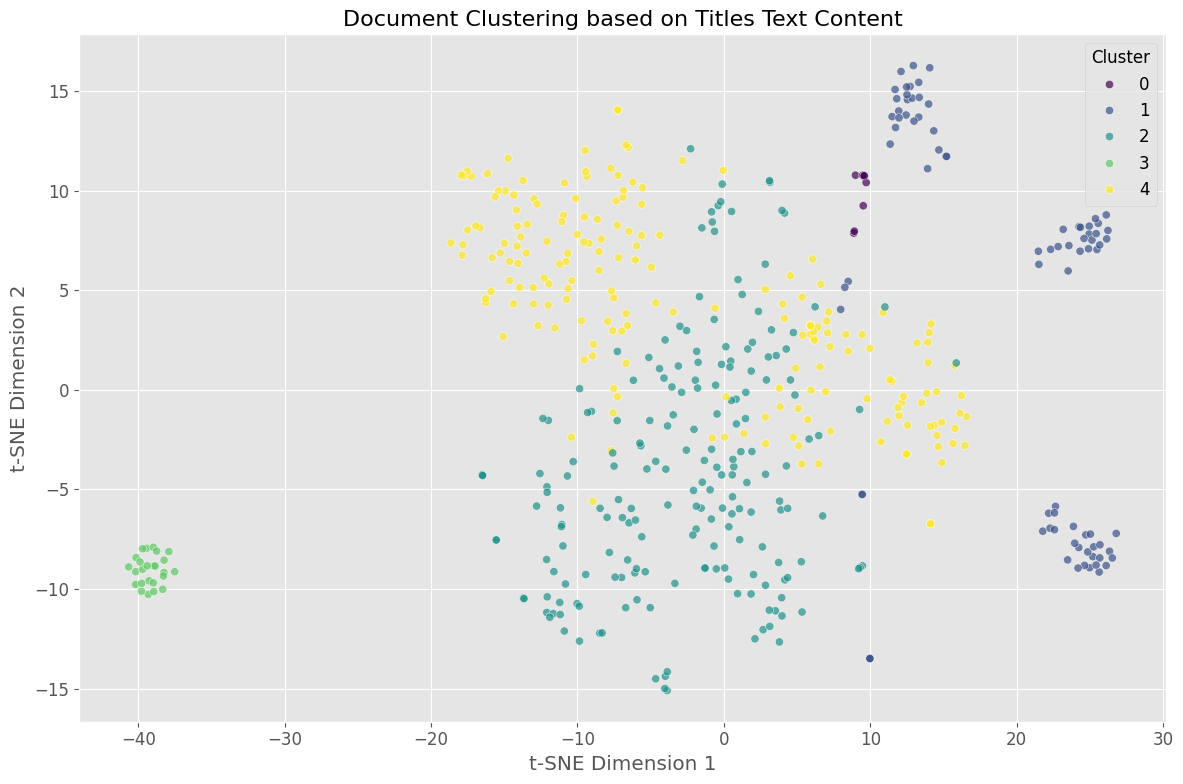

In [35]:
# Text clustering using embeddings and dimensionality reduction
from pyspark.ml.feature import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Use the cleaned word lists from earlier
# Train Word2Vec model to get document embeddings
w2v = Word2Vec(
    vectorSize=100,
    minCount=2,
    inputCol="clean_words",
    outputCol="document_vector"
)

# Train the model and transform the data - only using documents with words
titles_valid_docs = titles_cleaned_df.filter(
    F.size("clean_words") > 0)
titles_w2v_model = w2v.fit(titles_valid_docs)
titles_doc_vectors = titles_w2v_model.transform(
    titles_valid_docs)

# Convert to pandas for visualization
titles_doc_vectors_pd = titles_doc_vectors.select(
    "id", "document_vector").limit(500).toPandas()

# Convert vectors to numpy arrays for dimensionality reduction
titles_vectors = np.array(
    titles_doc_vectors_pd
    ['document_vector'].tolist())

# Apply t-SNE for dimensionality reduction
if len(titles_vectors) > 0:
    tsne = TSNE(n_components=2, random_state=42)
    titles_vectors_2d = tsne.fit_transform(titles_vectors)
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    titles_clusters = kmeans.fit_predict(titles_vectors)
    
    # Create visualization dataframe
    titles_viz_df = pd.DataFrame({
        'id': titles_doc_vectors_pd['id'],
        'x': titles_vectors_2d[:, 0],
        'y': titles_vectors_2d[:, 1],
        'cluster': titles_clusters
    })
    
    # Visualize clusters
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x='x',
        y='y',
        data=titles_viz_df,
        hue='cluster',
        palette='viridis',
        alpha=0.7)
    plt.title('Document Clustering based on Titles Text Content', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

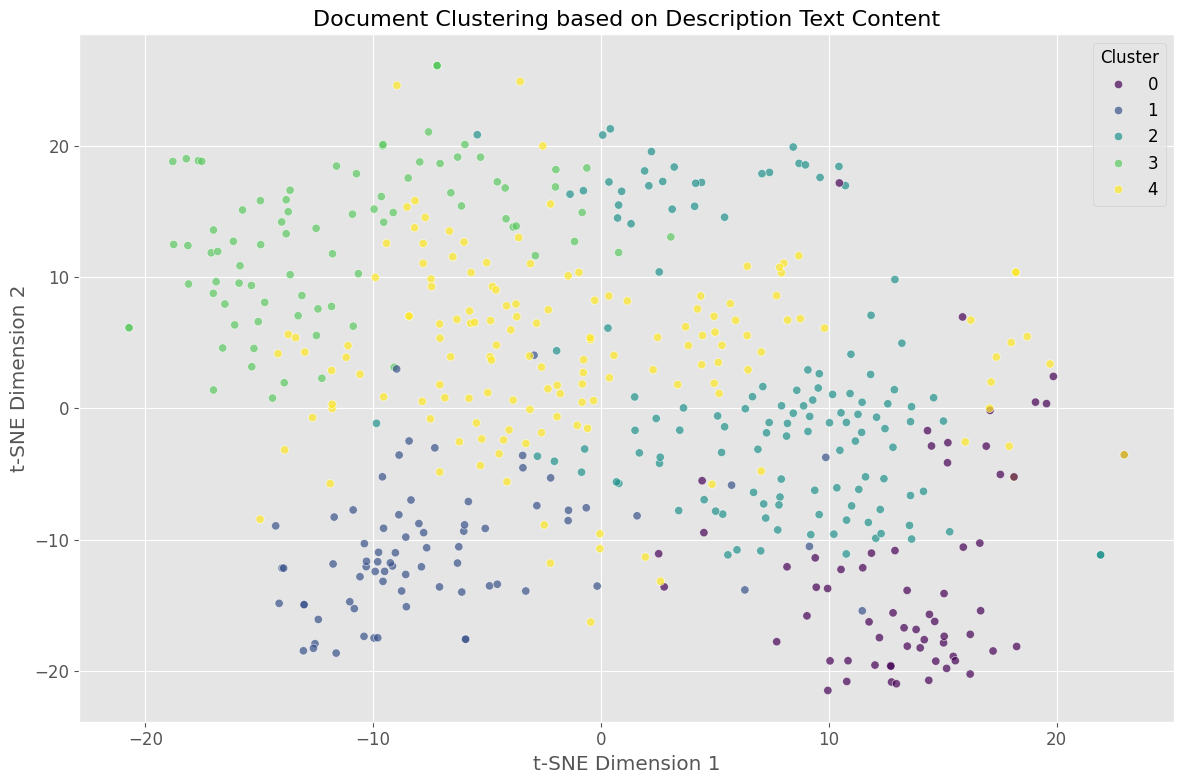

In [36]:
# Text clustering using embeddings and dimensionality reduction
from pyspark.ml.feature import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Use the cleaned word lists from earlier
# Train Word2Vec model to get document embeddings
w2v = Word2Vec(
    vectorSize=100,
    minCount=2,
    inputCol="clean_words",
    outputCol="document_vector"
)

# Train the model and transform the data - only using documents with words
descriptions_valid_docs = descriptions_cleaned_df.filter(
    F.size("clean_words") > 0)
descriptions_w2v_model = w2v.fit(descriptions_valid_docs)
descriptions_doc_vectors = descriptions_w2v_model.transform(descriptions_valid_docs)

# Convert to pandas for visualization
descriptions_doc_vectors_pd = descriptions_doc_vectors.select(
    "id", "document_vector").limit(500).toPandas()

# Convert vectors to numpy arrays for dimensionality reduction
descriptions_vectors = np.array(
    descriptions_doc_vectors_pd
    ['document_vector'].tolist())

# Apply t-SNE for dimensionality reduction
if len(descriptions_vectors) > 0:
    tsne = TSNE(n_components=2, random_state=42)
    descriptions_vectors_2d = tsne.fit_transform(descriptions_vectors)
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    descriptions_clusters = kmeans.fit_predict(descriptions_vectors)
    
    # Create visualization dataframe
    descriptions_viz_df = pd.DataFrame({
        'id': descriptions_doc_vectors_pd['id'],
        'x': descriptions_vectors_2d[:, 0],
        'y': descriptions_vectors_2d[:, 1],
        'cluster': descriptions_clusters
    })
    
    # Visualize clusters
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x='x',
        y='y',
        data=descriptions_viz_df,
        hue='cluster',
        palette='viridis',
        alpha=0.7)
    plt.title('Document Clustering based on Description Text Content', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

## Temporal Pattern Analysis

Let's analyze if the text data contains temporal references and patterns.

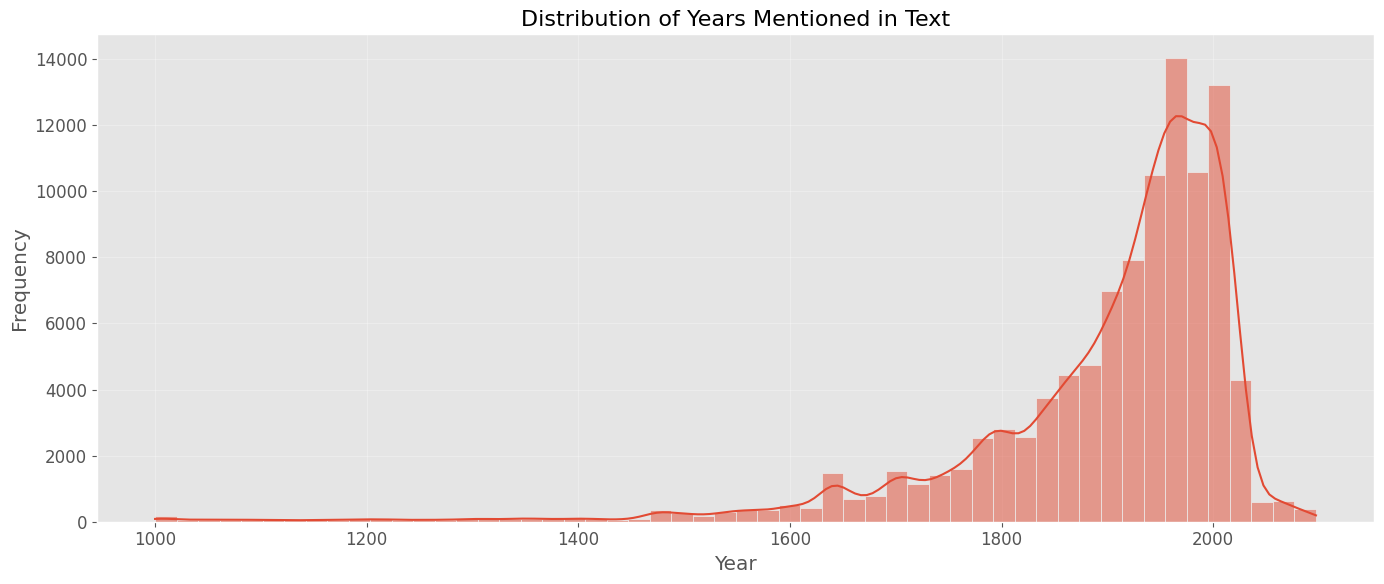


Most common years mentioned:
  - 2014: 3361
  - 2020: 2151
  - 1973: 1920
  - 1999: 1617
  - 1962: 1315
  - 1998: 952
  - 1996: 878
  - 1934: 783
  - 1993: 757
  - 1995: 740

Most common centuries mentioned:
  - 18th century: 553
  - 19th century: 170
  - 17th century: 123
  - 20th century: 90
  - 16th century: 69

Most common decades mentioned:
  - 2000s: 1392
  - 1970s: 229
  - 1980s: 228
  - 1950s: 204
  - 1930s: 101


In [78]:
# Extract and analyze temporal references in text
try:
    import re
    import pandas as pd
    from collections import Counter
    
    # Sample data for temporal analysis
    temporal_sample = df.select('id', 'title', 'description', 'note_contents').sample(False, 0.1).toPandas()
    
    # Regular expressions for finding years and centuries
    year_pattern = r'\b1[0-9]{3}\b|\b20[0-9]{2}\b'  # Years from 1000-2099
    century_pattern = r'\b(?:1[0-9]|20)th century\b|\b(?:1[0-9]|20)st century\b'  # 10th-21st century
    decade_pattern = r'\b(?:1[0-9]|20)[0-9]0s\b'  # 1000s-2090s decades
    
    # Function to extract temporal references
    def extract_temporal_refs(text):
        if pd.isna(text) or text.strip() == '':
            return [], [], []
            
        years = re.findall(year_pattern, text)
        centuries = re.findall(century_pattern, text)
        decades = re.findall(decade_pattern, text)
        
        return years, centuries, decades
    
    # Collect all temporal references
    all_years = []
    all_centuries = []
    all_decades = []
    
    # Process description and notes fields
    for _, row in temporal_sample.iterrows():
        for field in ['title', 'description', 'note_contents']:
            if pd.notna(row[field]) and row[field].strip():
                years, centuries, decades = extract_temporal_refs(row[field])
                all_years.extend(years)
                all_centuries.extend(centuries)
                all_decades.extend(decades)
    
    # Convert years to integers for histogram
    year_ints = [int(y) for y in all_years if y.isdigit()]
    # Year range
    year_range = max(year_ints) - min(year_ints)
    
    # Plot distribution of years mentioned
    if year_ints:
        plt.figure(figsize=(14, 6))
        sns.histplot(year_ints, bins=int(year_range / 20), kde=True)
        plt.title('Distribution of Years Mentioned in Text', fontsize=16)
        plt.xlabel('Year')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Show most common temporal references
    print("\nMost common years mentioned:")
    for year, count in Counter(all_years).most_common(10):
        print(f"  - {year}: {count}")
        
    print("\nMost common centuries mentioned:")
    for century, count in Counter(all_centuries).most_common(5):
        print(f"  - {century}: {count}")
        
    print("\nMost common decades mentioned:")
    for decade, count in Counter(all_decades).most_common(5):
        print(f"  - {decade}: {count}")
except Exception as e:
    print(f"Error in temporal analysis: {e}")

## Contextual Text Field Analysis

Let's explore how different text fields complement each other and provide context.

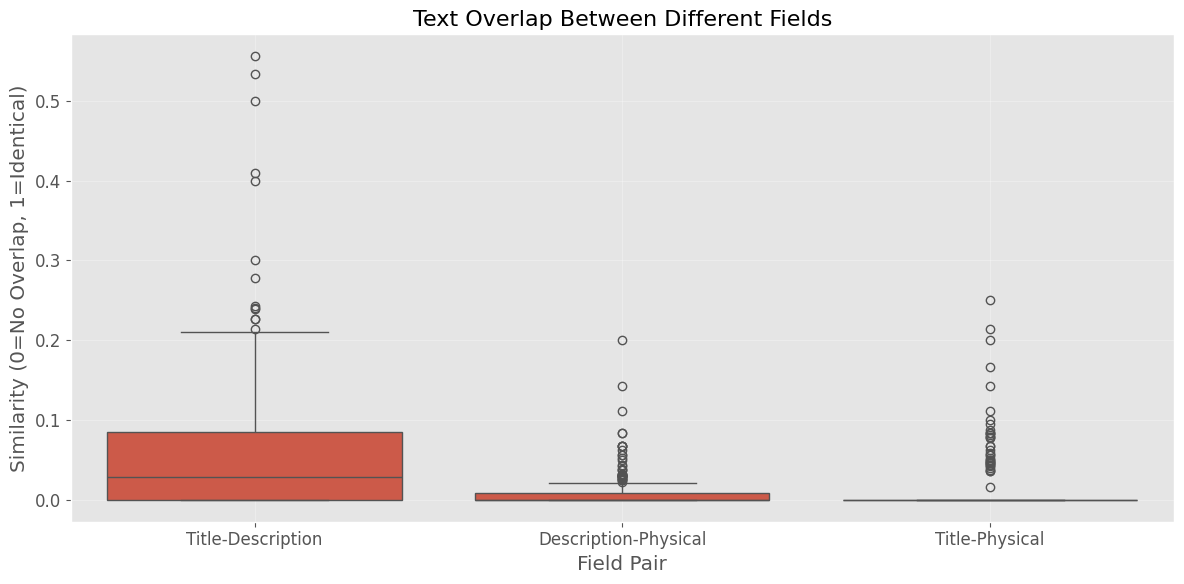

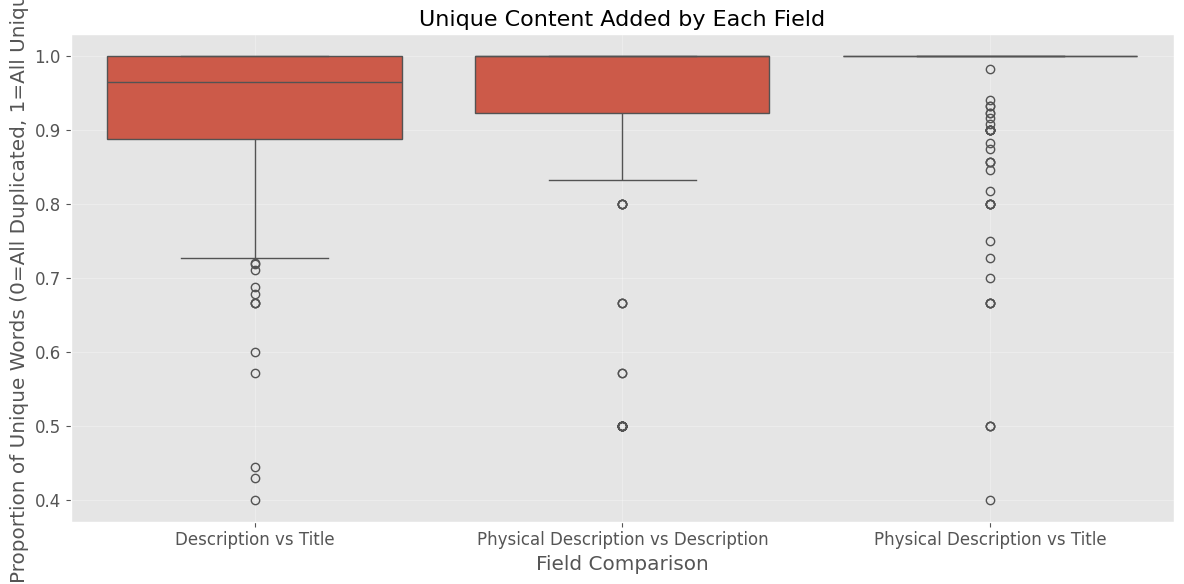

In [37]:
# Analyzing how different text fields complement each other
# Calculate overlap and uniqueness between fields

# Function to calculate text overlap metrics
def calculate_text_overlap(row, field1, field2):
    if pd.isna(row[field1]) or pd.isna(row[field2]) or len(row[field1].strip()) == 0 or len(row[field2].strip()) == 0:
        return np.nan, np.nan
    
    # Tokenize both fields
    words1 = set(row[field1].lower().split())
    words2 = set(row[field2].lower().split())
    
    # Calculate Jaccard similarity (intersection over union)
    intersection = words1.intersection(words2)
    union = words1.union(words2)
    jaccard = len(intersection) / len(union) if len(union) > 0 else 0
    
    # Calculate percentage of unique words in field2 not in field1
    unique_percentage = len(words2 - words1) / len(words2) if len(words2) > 0 else 0
    
    return jaccard, unique_percentage

# Sample data for overlap analysis
sample_fields = df.select(
    'id', 'title', 'description', 'physicalDescription', 'note_contents'
).filter(
    (F.length('title') > 0) & 
    (F.length('description') > 0) & 
    (F.length('physicalDescription') > 0)
).limit(200).toPandas()

# Calculate overlap metrics
overlap_data = []
for _, row in sample_fields.iterrows():
    # Title-Description overlap
    title_desc_jaccard, title_desc_unique = calculate_text_overlap(row, 'title', 'description')
    
    # Description-Physical overlap
    desc_phys_jaccard, desc_phys_unique = calculate_text_overlap(row, 'description', 'physicalDescription')
    
    # Title-Physical overlap
    title_phys_jaccard, title_phys_unique = calculate_text_overlap(row, 'title', 'physicalDescription')
    
    overlap_data.append({
        'id': row['id'],
        'title_desc_similarity': title_desc_jaccard,
        'title_desc_uniqueness': title_desc_unique,
        'desc_phys_similarity': desc_phys_jaccard,
        'desc_phys_uniqueness': desc_phys_unique,
        'title_phys_similarity': title_phys_jaccard,
        'title_phys_uniqueness': title_phys_unique
    })

overlap_df = pd.DataFrame(overlap_data)

# Plot similarity between fields
plt.figure(figsize=(12, 6))
similarity_data = pd.DataFrame({
    'Title-Description': overlap_df['title_desc_similarity'].dropna(),
    'Description-Physical': overlap_df['desc_phys_similarity'].dropna(),
    'Title-Physical': overlap_df['title_phys_similarity'].dropna()
})
similarity_melted = pd.melt(similarity_data, var_name='Field Pair', value_name='Jaccard Similarity')

sns.boxplot(x='Field Pair', y='Jaccard Similarity', data=similarity_melted)
plt.title('Text Overlap Between Different Fields', fontsize=16)
plt.ylabel('Similarity (0=No Overlap, 1=Identical)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot uniqueness between fields
plt.figure(figsize=(12, 6))
uniqueness_data = pd.DataFrame({
    'Description vs Title': overlap_df['title_desc_uniqueness'].dropna(),
    'Physical Description vs Description': overlap_df['desc_phys_uniqueness'].dropna(),
    'Physical Description vs Title': overlap_df['title_phys_uniqueness'].dropna()
})
uniqueness_melted = pd.melt(uniqueness_data, var_name='Field Comparison', value_name='Unique Information')

sns.boxplot(x='Field Comparison', y='Unique Information', data=uniqueness_melted)
plt.title('Unique Content Added by Each Field', fontsize=16)
plt.ylabel('Proportion of Unique Words (0=All Duplicated, 1=All Unique)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
## Conclusions and Insights

Based on our text analysis, here are some key findings:

1. **Text Length Distribution**: We've examined how text length varies across different fields, helping understand the relative information density in each field.

2. **Text Complexity**: We've measured lexical diversity and average word length to gauge the complexity of language used in different text fields.

3. **Common Terms and Phrases**: Through term frequency and n-gram analysis, we've identified the most common terms and phrases that characterize the collection.

4. **Topic Modeling**: We've discovered latent topics in the collection, revealing thematic patterns that might not be explicitly categorized.

5. **Named Entity Recognition**: We've identified people, places, organizations and other entities mentioned in the texts, providing insight into what the collection references.

6. **Sentiment and Subjectivity**: We've analyzed the emotional tone and subjectivity of different text fields.

7. **Temporal References**: We've extracted and analyzed time-related information to understand the historical periods referenced in the collection.

8. **Text Field Complementarity**: We've examined how different text fields complement each other by measuring overlap and unique information.

These analyses provide a rich understanding of the textual content in the works collection, which can inform further research, curation decisions, and search functionality improvements.